In [1]:
import os
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import h5py
from oasis.functions import deconvolve
from oasis import oasisAR1, oasisAR2
import pyute as ut

from importlib import reload
reload(ut)
import scipy.ndimage.filters as sfi
import scipy.stats as sst
import scipy.ndimage.measurements as snm
from mpl_toolkits.mplot3d import Axes3D
import size_contrast_opto_analysis as scoa
reload(scoa)
import retinotopy_analysis as rt
reload(rt)
import naka_rushton_analysis as nra
import pdb
import size_contrast_analysis as sca
import skimage.segmentation as sks
import skimage.morphology as skm
import sklearn

/Users/dan/Documents/code/downloads/OASIS/oasis/functions.py:14: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  "just not the slower interior point methods we compared to in the papers.")


In [2]:
dsname = '/Users/dan/Documents/notebooks/mossing-PC/shared_data/pyr_l23_data_struct.hdf5'

In [3]:
with ut.hdf5read(dsname) as ds:
    keylist = list(ds.keys())

In [4]:
with ut.hdf5read(dsname) as ds:
    for k in range(len(keylist)):
        nangle = 8
#         print(list(ds[keylist[k]]['size_contrast_0'].keys()))
        pval_ret = ds[keylist[k]]['size_contrast_0']['rf_mapping_pval'][()]
        dist_ret = ds[keylist[k]]['size_contrast_0']['rf_distance_deg'][()]
        ontarget_ret_lax = np.logical_and(dist_ret<20,pval_ret<0.05)
        print(ontarget_ret_lax.sum())

1050
505
703
531
334
178
446
665
735
632


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


In [5]:
keylist[1]

'session_181209_M8536'

In [6]:
with ut.hdf5read(dsname) as ds:
    for k in range(len(keylist)):
        print(np.nanmean(ds[keylist[k]]['size_contrast_0']['running_speed_cm_s'][()]))

5.97442237118107
5.009098853764588
49.94960494121323
18.626879105279418
18.99242821728237
1.4777243782442844
44.72053800214469
1.6038259808529527
1.3766074256792236
34.49618813269872


<IPython.core.display.Javascript object>


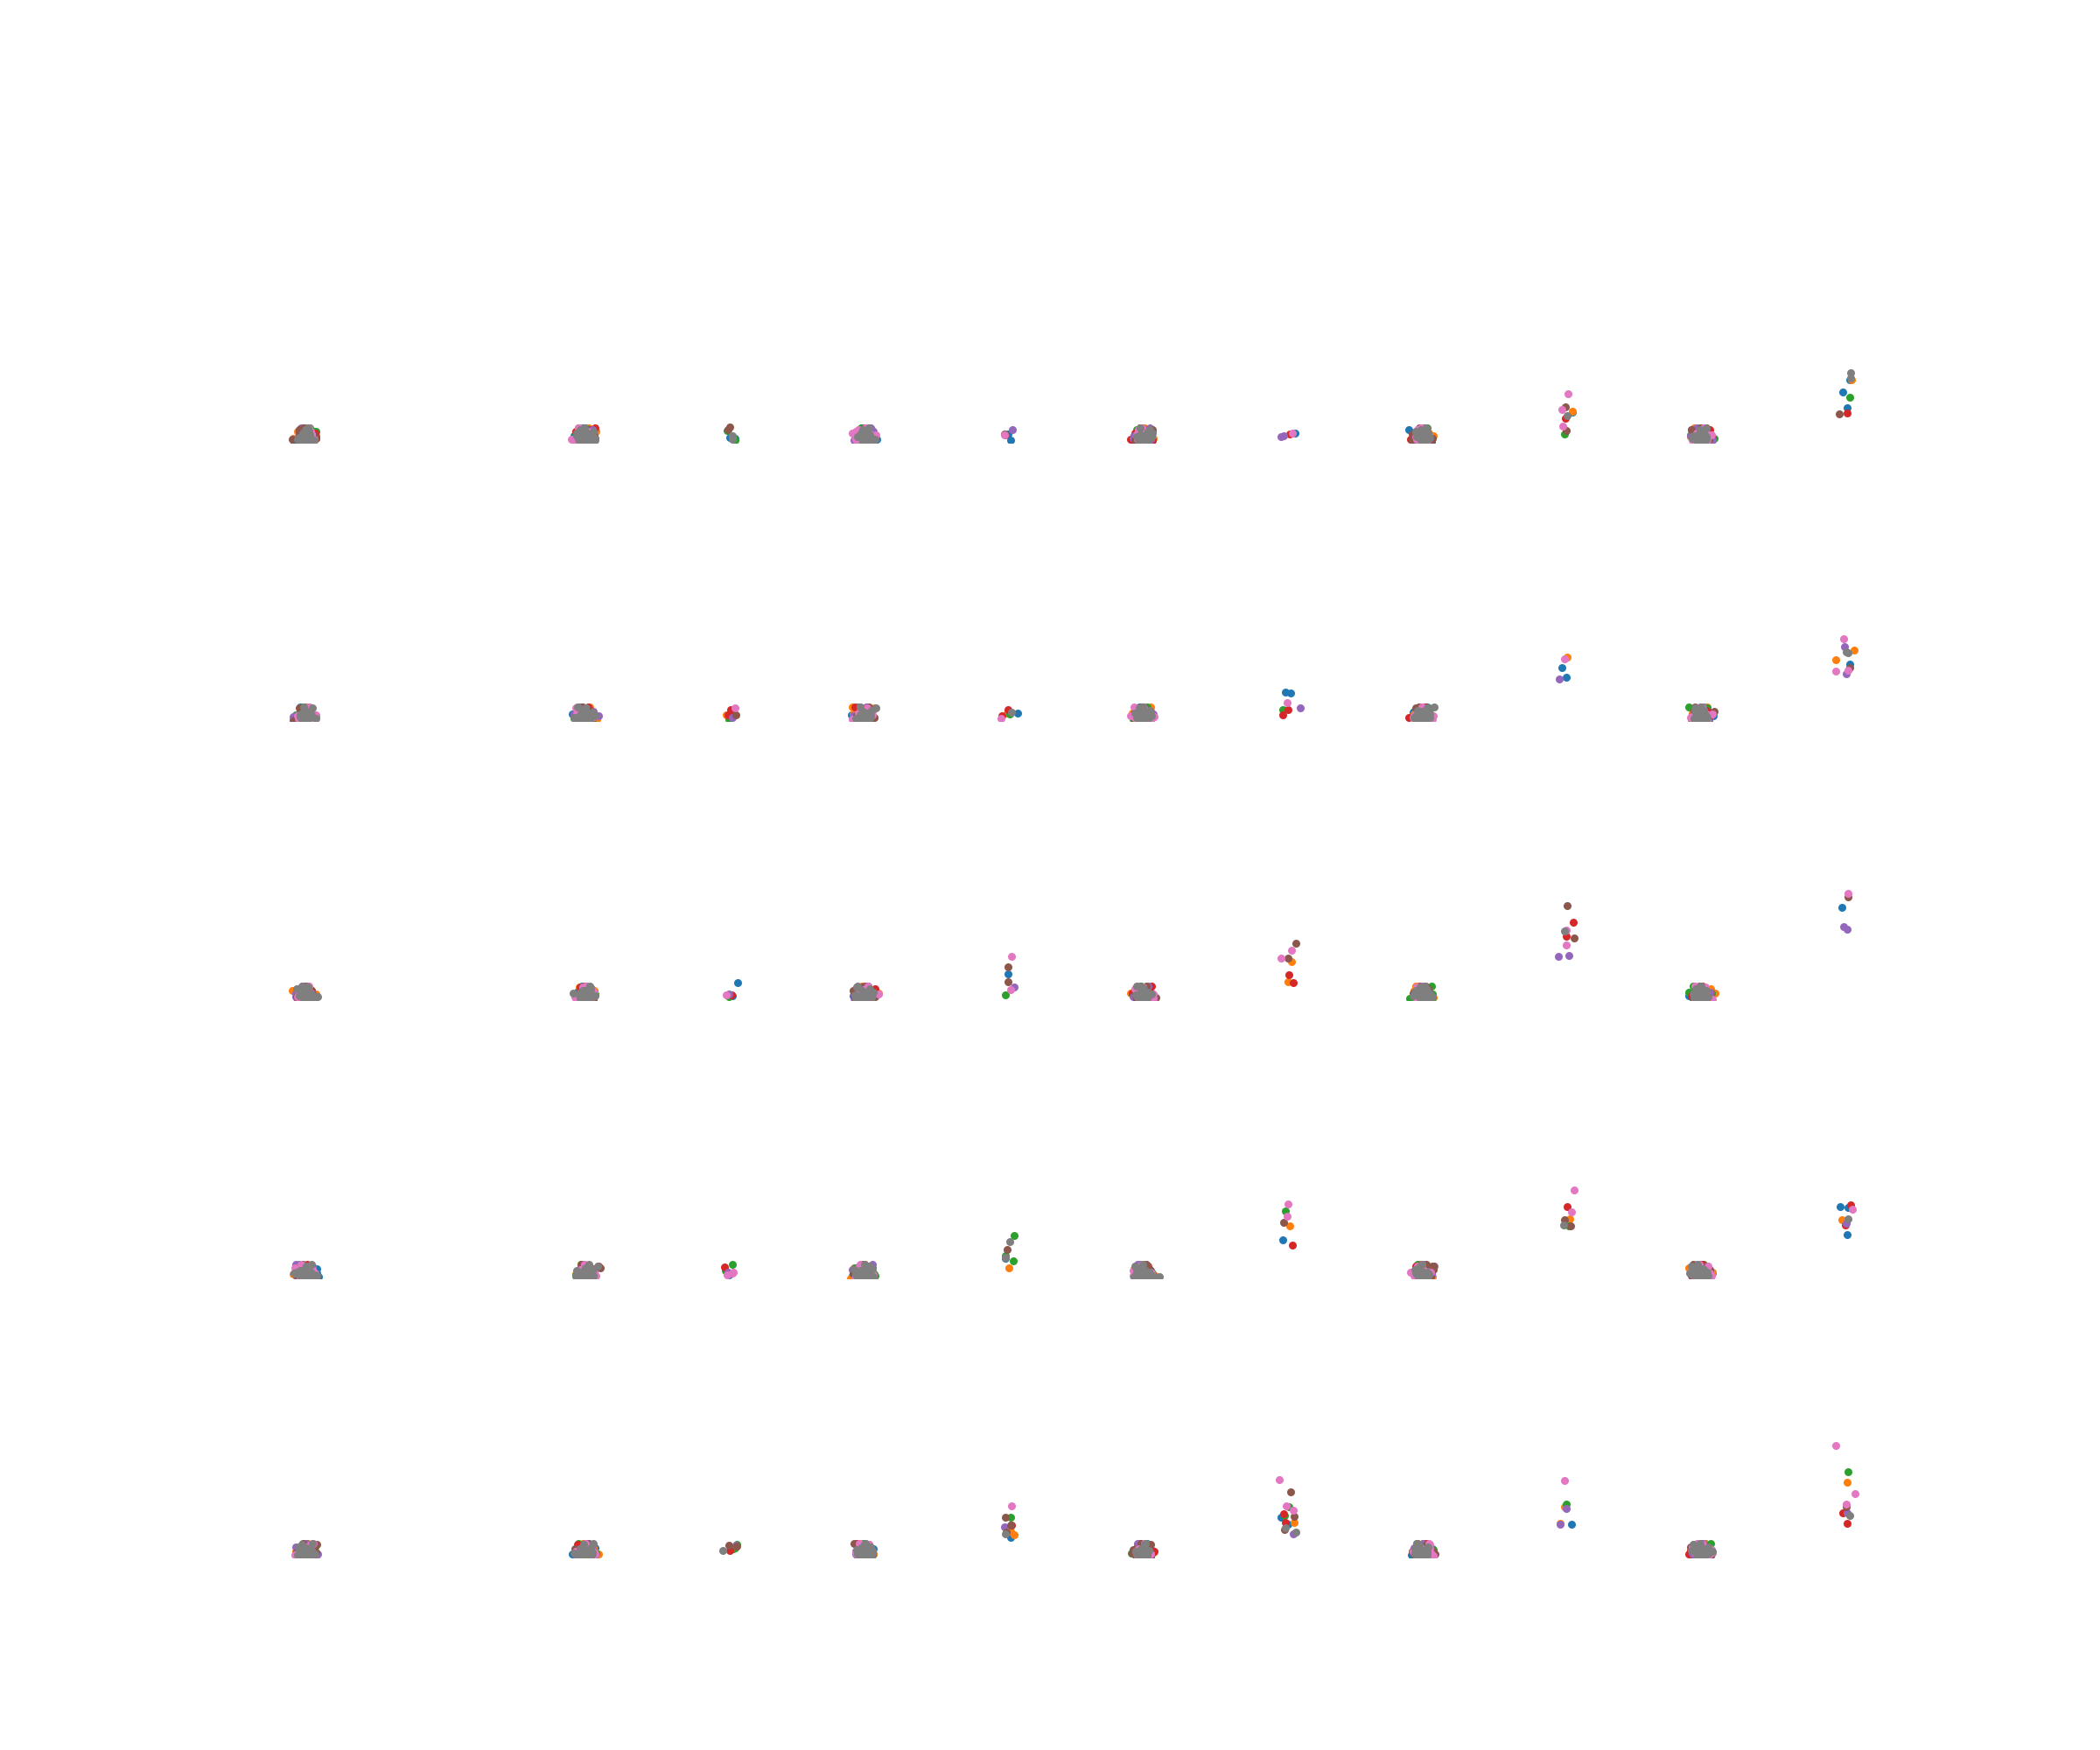

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less


In [7]:
# Here, we plot the distribution of responses to zero-contrast vs. non-zero contrast stimuli, for all the on-target neurons in a particular mouse
k = 1
plt.figure(figsize=(12,10))
nsize = 5
ncontrast = 6
nangle = 8
with ut.hdf5read(dsname) as ds:
    sc0 = ds[keylist[k]]['size_contrast_0']
    size = sc0['stimulus_id'][()][0]
    contrast = sc0['stimulus_id'][()][1]
    running_speed_cm_s = np.nanmean(sc0['running_speed_cm_s'][()],-1)
    angle = sc0['stimulus_id'][()][-1]
    pval_ret = sc0['rf_mapping_pval'][()]
    dist_ret = sc0['rf_distance_deg'][()]
    nbefore = sc0['nbefore'][()]
    nafter = sc0['nafter'][()]
    ontarget_ret_lax = np.logical_and(dist_ret<40,pval_ret<0.05)
    for s in range(nsize):
        for c in range(ncontrast):
            plt.subplot(nsize,ncontrast,s*ncontrast+c+1)
            all_or_nothing = np.logical_or(contrast==0,contrast==c)
            for i in range(nangle): #(nangle):
                stim_of_interest = np.logical_and(np.logical_and(np.logical_or(np.logical_and(angle==i,size==s),contrast==0),running_speed_cm_s>7),all_or_nothing)
#                 print(stim_of_interest.shape)
#                 print(sc0['decon'][()].shape)
                nonzero_stim = contrast[stim_of_interest]>0
                X = np.nanmean(sc0['decon'][()][:,:,nbefore:-nafter],2).T[stim_of_interest][:,ontarget_ret_lax]
                y = nonzero_stim.copy()
                avg_across_rois = X.mean(1)
                plt.scatter(nonzero_stim+0.03*np.random.randn(nonzero_stim.size),avg_across_rois,s=5)
                plt.ylim((0,0.3))
                plt.xlim((-0.3,1.3))
                plt.axis('off')

In [8]:
k = 1
data = sst.zscore(ds[keylist[k]]['decon'][()],axis=1)
data[np.isnan(data)] = 0
u,s,v = np.linalg.svd(data)

ValueError: Not a location (invalid object ID)

In [9]:
v.shape

NameError: name 'v' is not defined

<IPython.core.display.Javascript object>


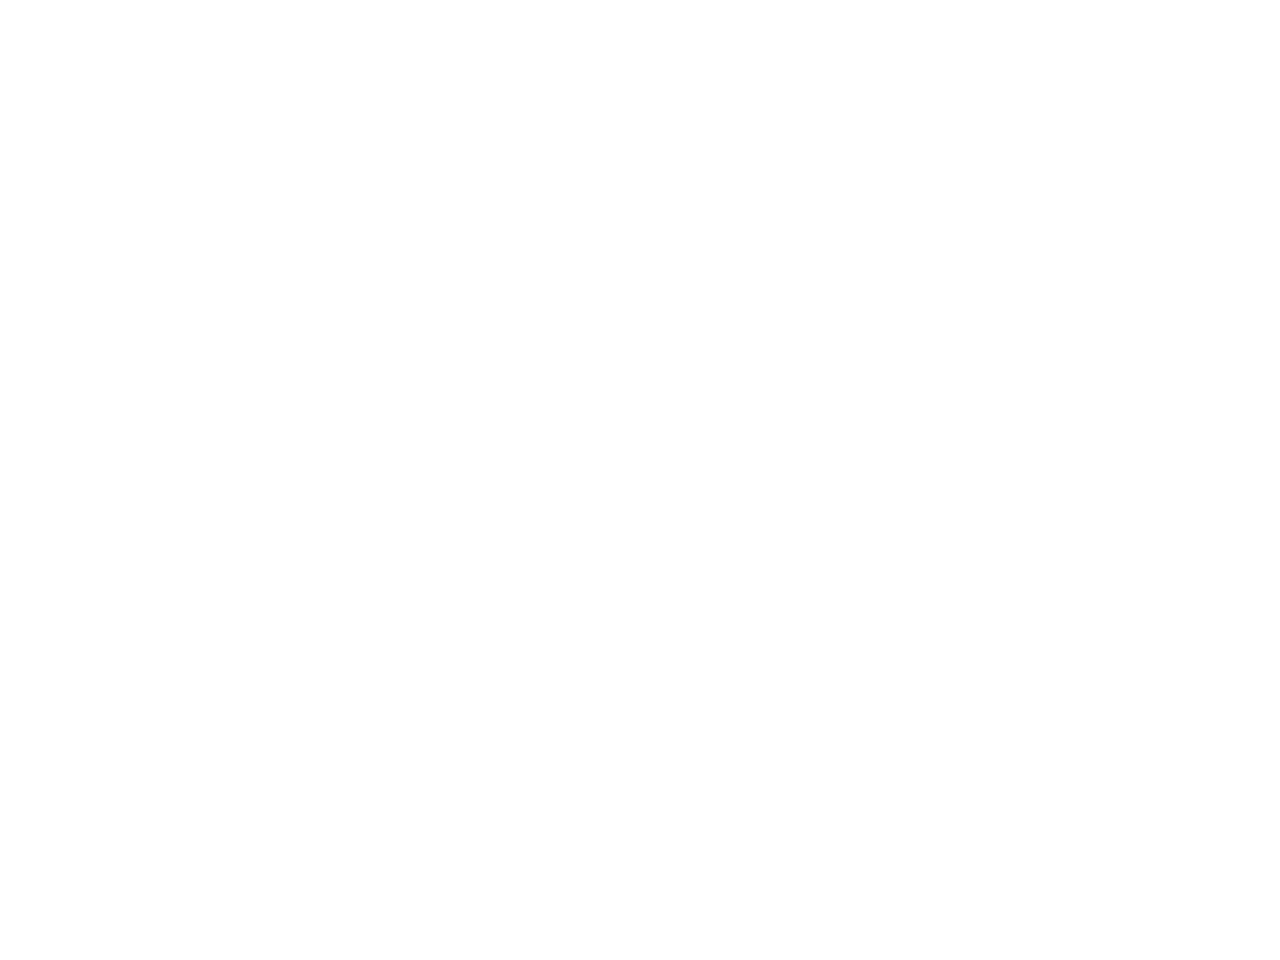

AttributeError: 'int' object has no attribute 'sum'

In [10]:
plt.figure()
plt.plot(np.cumsum(s)/s.sum())
plt.figure()
plt.plot(u[:,:5])

In [11]:
matfile = sio.loadmat('/home/mossing/Documents/notebooks/eye_tracking/eye_tracking_181213_M8536.mat',squeeze_me=True)
ctrx_trialwise = matfile['ctrx_trialwise']
ctry_trialwise = matfile['ctry_trialwise']
area_trialwise = matfile['area_trialwise']

FileNotFoundError: [Errno 2] No such file or directory: '/home/mossing/Documents/notebooks/eye_tracking/eye_tracking_181213_M8536.mat'

In [ ]:
def trialavg(arr):
    return np.nanmean(arr[:,nbefore:-nafter],1)
ctrx = trialavg(ctrx_trialwise)
ctry = trialavg(ctry_trialwise)
area = trialavg(area_trialwise)

In [ ]:
plt.figure()
plt.plot(ctrx_trialwise[0])

In [ ]:
plt.figure()
plt.scatter(ctrx[:700],ctrx[700:])

<IPython.core.display.Javascript object>


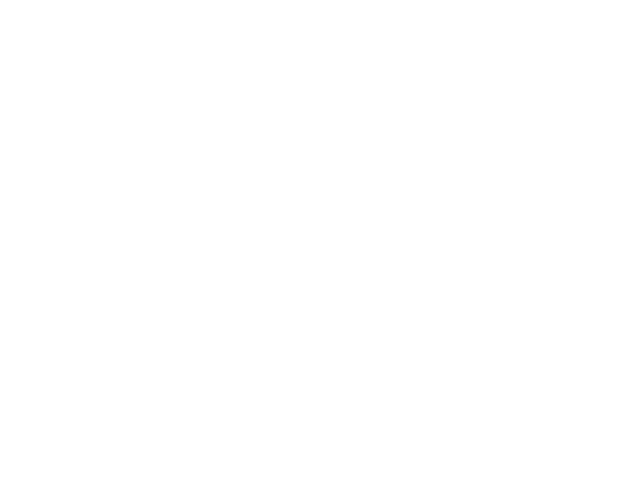

In [133]:
%matplotlib notebook
plt.figure()
eye_dist = np.sqrt((ctrx-np.nanmean(ctrx))**2+(ctry-np.nanmean(ctry))**2)
plt.plot(eye_dist)
plt.plot(area/area.max())

In [41]:
k = 1
with ut.hdf5read(dsname) as ds:
    sc0 = ds[keylist[k]]['size_contrast_0']
    data = sst.zscore(sc0['decon'][()],axis=1)
# plt.scatter(data)

/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/scipy/stats/stats.py:2313: RuntimeWarning: divide by zero encountered in true_divide
  np.expand_dims(sstd, axis=axis))
/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/scipy/stats/stats.py:2313: RuntimeWarning: invalid value encountered in true_divide
  np.expand_dims(sstd, axis=axis))


In [87]:
with ut.hdf5read(dsname) as ds:
    for k in (0,):
        sc0 = ds[keylist[k]]['size_contrast_0']
        print(list(sc0['stimulus_size_deg']))

[5.000000000000001, 8.218654417271205, 13.509256086106294, 22.20558144122508, 36.49999999999999]


session_181205_M10130
session_181209_M8536


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:2313: RuntimeWarning: divide by zero encountered in true_divide
  np.expand_dims(sstd, axis=axis))
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:2313: RuntimeWarning: invalid value encountered in true_divide
  np.expand_dims(sstd, axis=axis))
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


session_181213_M8536


<IPython.core.display.Javascript object>


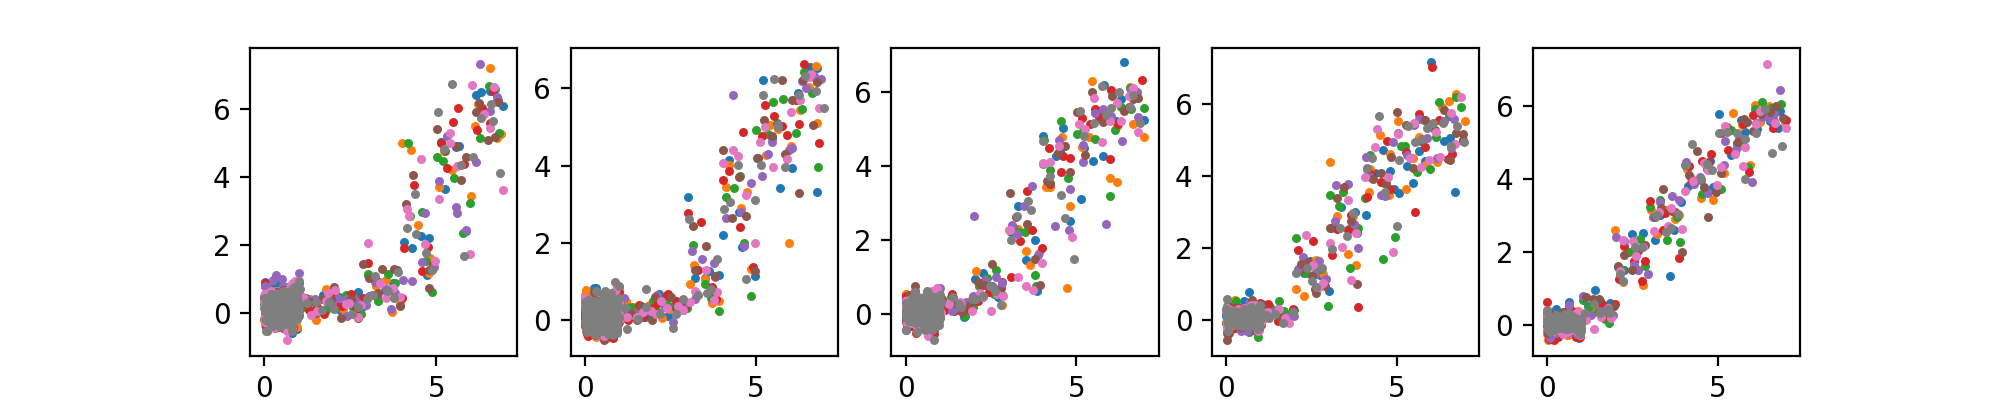

(0, 20, 0.7148349216871761)
(0, 20, 0.6658191552356797)
(0, 20, 0.7054252580837209)
(0, 20, 0.641009793223547)
(0, 20, 0.62910111491496)
(0, 20, 0.7616036350600504)
(0, 20, 0.6905391812931768)
(0, 20, 0.6920201846113712)
(1, 20, 0.716556512928687)
(1, 20, 0.7312336526611309)
(1, 20, 0.7822613707825276)
(1, 20, 0.8277912882640528)
(1, 20, 0.8100305731003171)
(1, 20, 0.810489306758744)
(1, 20, 0.794735468018535)
(1, 20, 0.7442842958808775)
(2, 20, 0.8667973439647811)
(2, 20, 0.8226580403087127)
(2, 20, 0.8702613662104335)
(2, 20, 0.8718319606215055)
(2, 20, 0.8730484956023401)
(2, 20, 0.8889892962964684)
(2, 20, 0.8187801020749064)
(2, 20, 0.8351393963788627)
(3, 20, 0.8751083498712637)
(3, 20, 0.915203394754229)
(3, 20, 0.9059264287189424)
(3, 20, 0.8714931823550959)
(3, 20, 0.9262993923134051)
(3, 20, 0.924346231023787)
(3, 20, 0.8946442436899398)
(3, 20, 0.9211598730676291)
(4, 20, 0.9552620866751408)
(4, 20, 0.9238310950648824)
(4, 20, 0.9652309298023859)
(4, 20, 0.9475508614522081)


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:2313: RuntimeWarning: divide by zero encountered in true_divide
  np.expand_dims(sstd, axis=axis))
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:2313: RuntimeWarning: invalid value encountered in true_divide
  np.expand_dims(sstd, axis=axis))
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


<IPython.core.display.Javascript object>


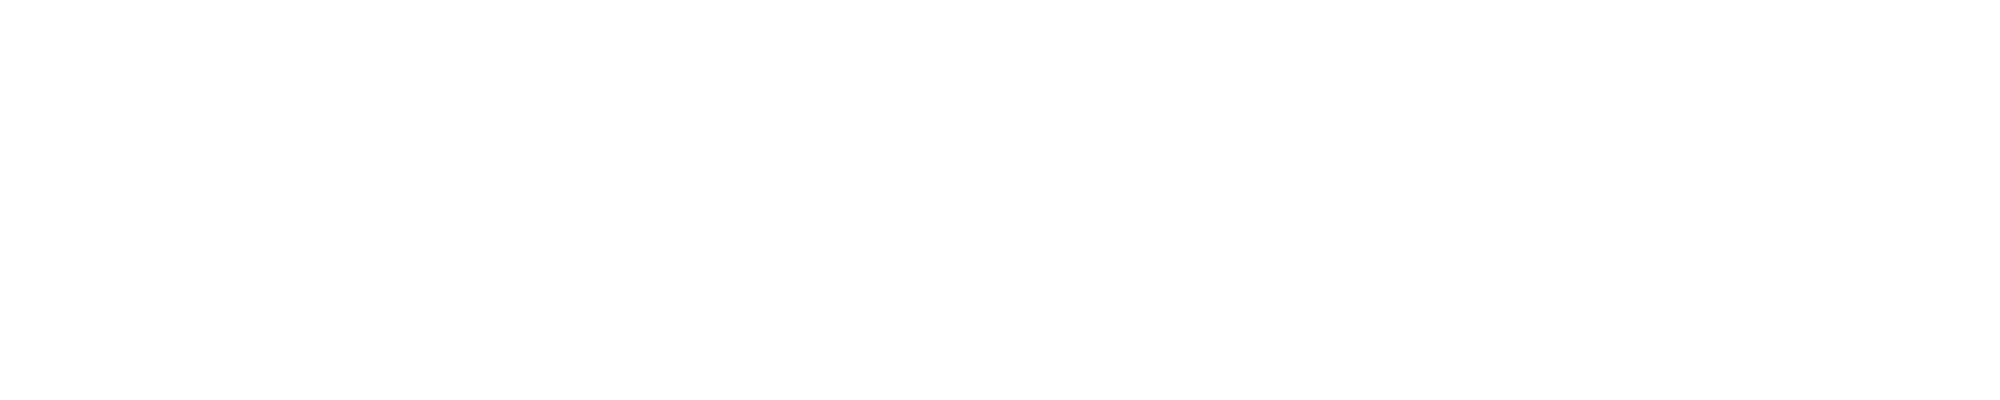

(0, 20, 0.8780636753400113)
(0, 20, 0.8511664048257408)
(0, 20, 0.9475514456079803)
(0, 20, 0.8854999575149174)
(0, 20, 0.5104484603329031)
(0, 20, 0.8595337675034967)
(0, 20, 0.8953481831550079)
(0, 20, 0.7023082820511151)
(1, 20, 0.7988699262988757)
(1, 20, 0.9088872826363943)
(1, 20, 0.910497273143719)
(1, 20, 0.8533682971065272)
(1, 20, 0.9006022928907192)
(1, 20, 0.8358630267605809)
(1, 20, 0.9037623344750291)
(1, 20, 0.9108566645938714)
(2, 20, 0.8949354811781216)
(2, 20, 0.9061527412715604)
(2, 20, 0.9245591806660857)
(2, 20, 0.9376781169869849)
(2, 20, 0.942561896189733)
(2, 20, 0.847319189829365)
(2, 20, 0.9459378339257889)
(2, 20, 0.9394156320138913)
(3, 20, 0.9070428232786518)
(3, 20, 0.728972208969089)
(3, 20, 0.8082937982139267)
(3, 20, 0.884844049969538)
(3, 20, 0.8879603003024072)
(3, 20, 0.8816904035618517)
(3, 20, 0.9173315887392507)
(3, 20, 0.9110977165425374)
(4, 20, 0.788570610537718)
(4, 20, 0.8427129411331903)
(4, 20, 0.8607433041623855)
(4, 20, 0.8595146960722244

<IPython.core.display.Javascript object>


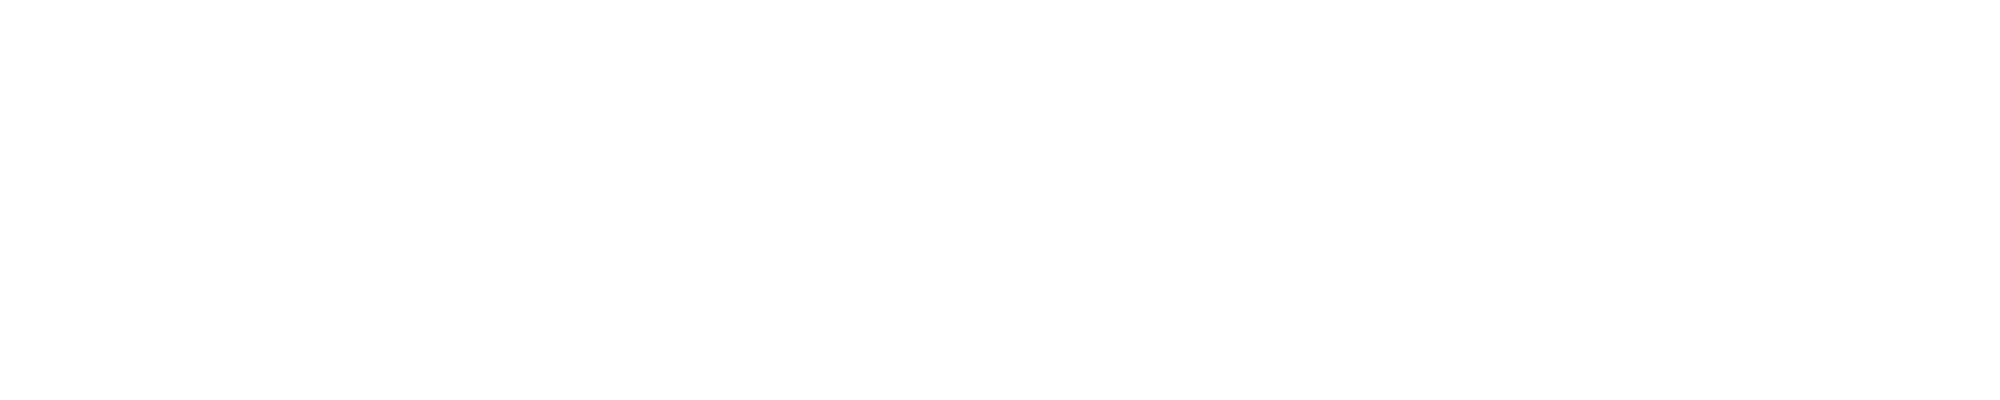

(0, 20, 0.16124517985015369)
(0, 20, 0.03305457141444974)
(0, 20, 0.13363026688036783)
(0, 20, -0.2465064503766902)
(0, 20, 0.05737527277633407)
(0, 20, 0.1673021406559128)
(0, 20, 0.02176706880995378)
(0, 20, 0.007662168618463622)
(1, 20, 0.1433661509149944)
(1, 20, 0.43945339665278527)
(1, 20, 0.18843513429112396)
(1, 20, 0.534436198437479)
(1, 20, 0.4821534720136148)
(1, 20, 0.22780495071721857)
(1, 20, 0.26437681505107824)
(1, 20, 0.3432727197994333)
(2, 20, 0.8032372526727469)
(2, 20, 0.6541165416399711)
(2, 20, 0.8425624280309997)
(2, 20, 0.8361972868166981)
(2, 20, 0.8750133060488483)
(2, 20, 0.7816951080339791)
(2, 20, 0.6862911795430501)
(2, 20, 0.8415861368712996)
(3, 20, 0.957054643814762)
(3, 20, 0.9340393312175485)
(3, 20, 0.8514704061397842)
(3, 20, 0.9165138372744874)
(3, 20, 0.9247530518907212)
(3, 20, 0.9329161963307353)
(3, 20, 0.8909577002471618)
(3, 20, 0.9205900537804638)
(4, 20, 0.9066613703174372)
(4, 20, 0.9227755472073099)
(4, 20, 0.9134036919780956)
(4, 20, 0.

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:2313: RuntimeWarning: divide by zero encountered in true_divide
  np.expand_dims(sstd, axis=axis))
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:2313: RuntimeWarning: invalid value encountered in true_divide
  np.expand_dims(sstd, axis=axis))
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


session_190130_M9667


<IPython.core.display.Javascript object>


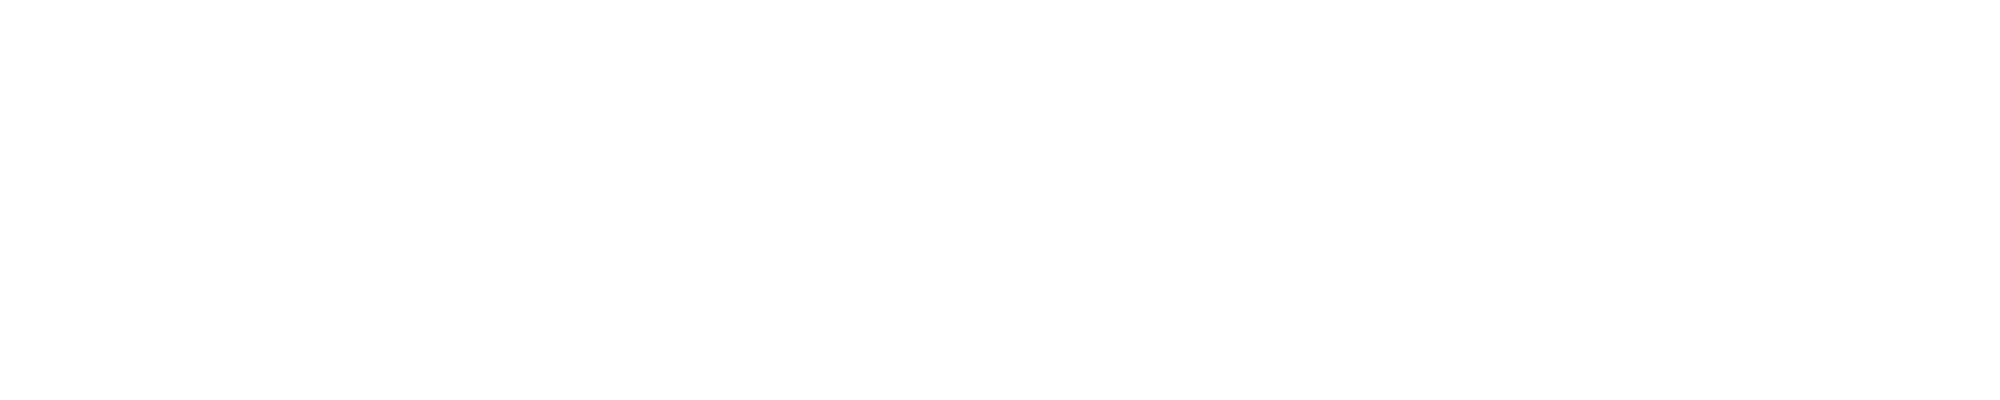

(0, 20, 0.2412739344534484)
(0, 20, 0.4012597850008369)
(0, 20, 0.40937769811915636)
(0, 20, 0.7124746202668443)
(0, 20, 0.6774154754249896)
(0, 20, 0.4529424650638161)
(0, 20, 0.08800075407399911)
(0, 20, 0.49807897220139896)
(1, 20, 0.3919290523589286)
(1, 20, 0.6940899879365532)
(1, 20, 0.533818263504681)
(1, 20, 0.5151078672977861)
(1, 20, 0.7069427188808712)
(1, 20, 0.6606105057962811)
(1, 20, 0.6687737047609171)
(1, 20, 0.6810630894027033)
(2, 20, 0.6939300606753683)
(2, 20, 0.638555846271329)
(2, 20, 0.5525140706709628)
(2, 20, 0.529894437663622)
(2, 20, 0.6687213425582823)
(2, 20, 0.651493385812597)
(2, 20, 0.7741360510252155)
(2, 20, 0.5292124976233004)
(3, 20, 0.7760652256406807)
(3, 20, 0.7205973024794493)
(3, 20, 0.6939616999937516)
(3, 20, 0.8175117897517412)
(3, 20, 0.7597385954307008)
(3, 20, 0.19374620312566632)
(3, 20, 0.7317879289765836)
(3, 20, 0.13249998520378803)
(4, 20, 0.731752103023414)
(4, 20, 0.6787673548834913)
(4, 20, 0.6832986284451021)
(4, 20, 0.5061313195

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:2313: RuntimeWarning: divide by zero encountered in true_divide
  np.expand_dims(sstd, axis=axis))
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:2313: RuntimeWarning: invalid value encountered in true_divide
  np.expand_dims(sstd, axis=axis))
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


session_190208_M9355
session_190212_M8536


<IPython.core.display.Javascript object>


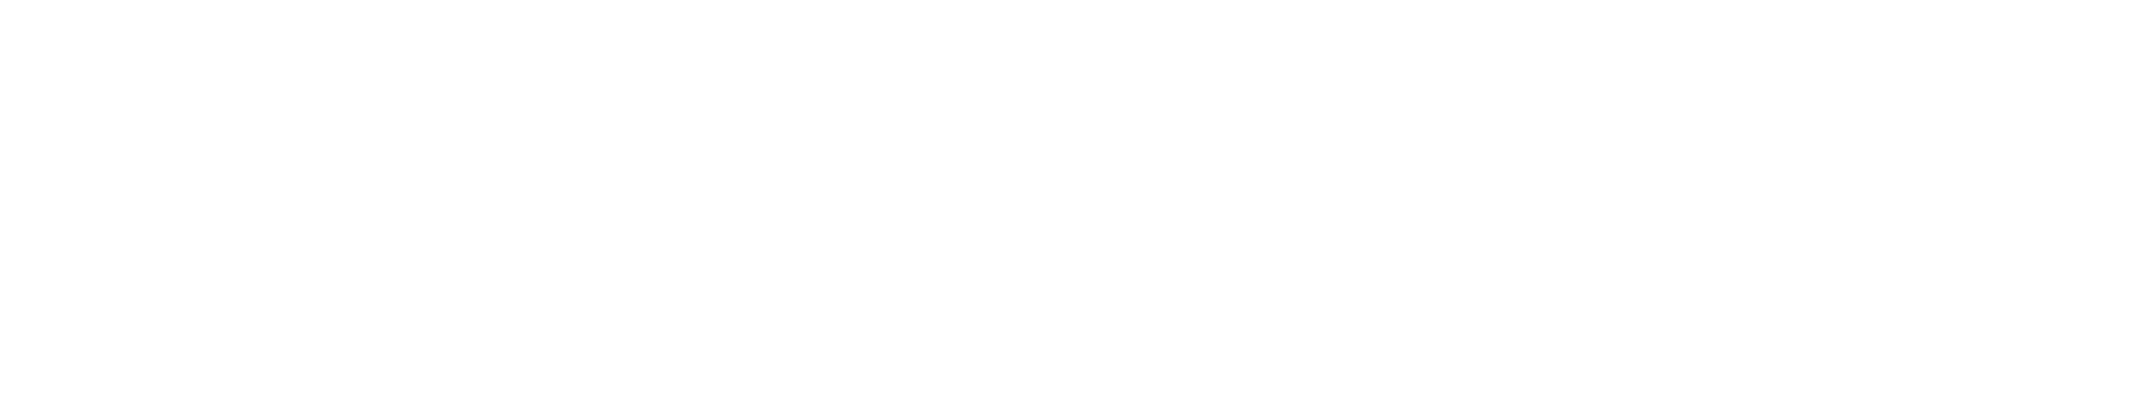

(0, 20, 0.6046486801096816)
(0, 20, 0.8352693046005285)
(0, 20, 0.7367674569559899)
(0, 20, 0.6399684258607501)
(0, 20, 0.7123293245477484)
(0, 20, 0.8310274642287521)
(0, 20, 0.7958271757107782)
(0, 20, 0.7615310541460132)
(1, 20, 0.8926135243348028)
(1, 20, 0.8197413946056138)
(1, 20, 0.8686485659960297)
(1, 20, 0.7634609206973757)
(1, 20, 0.888568790216268)
(1, 20, 0.7971677581536041)
(1, 20, 0.8814878383671794)
(1, 20, 0.7663454552735229)
(2, 20, 0.903809720978052)
(2, 20, 0.5288755626965633)
(2, 20, 0.8559554730885562)
(2, 20, 0.9079951614738911)
(2, 20, 0.7872567190844472)
(2, 20, 0.7250936680750573)
(2, 20, 0.8793618058554398)
(2, 20, 0.9186341266642891)
(3, 20, 0.9495253044530333)
(3, 20, 0.9672798934375446)
(3, 20, 0.9303670058743687)
(3, 20, 0.8929609947142506)
(3, 20, 0.9323041737335153)
(3, 20, 0.9128807801282994)
(3, 20, 0.9269140492082751)
(3, 20, 0.9186074517884666)
(4, 20, 0.9010463463620357)
(4, 20, 0.8817170776945925)
(4, 20, 0.9219473925666339)
(4, 20, 0.912666788800

In [92]:
nkey = len(keylist)
nangle = 8
R = [None for k in range(nkey)]
reg = [None for k in range(nkey)]
top_score = [None]*nkey
cutoffs = np.round(np.arange(20,21)).astype('int')
# cutoffs = (50,)
proc = [{} for k in range(len(keylist))]
with ut.hdf5read(dsname) as ds:
    for k in range(len(keylist)):
        print(keylist[k])
        R[k] = [None for icutoff in range(len(cutoffs))]
        reg[k] = [None for icutoff in range(len(cutoffs))]
        sc0 = ds[keylist[k]]['size_contrast_0']
        decon = np.nanmean(sc0['decon'][()][:,:,nbefore:-nafter],-1)
        data = sst.zscore(decon,axis=1)
        data[np.isnan(data)] = 0

        u,sigma,v = np.linalg.svd(data)

        pval_ret = sc0['rf_mapping_pval'][()]
        dist_ret = sc0['rf_distance_deg'][()]
        ontarget_ret_lax = np.logical_and(dist_ret<40,pval_ret<0.05)
        running_speed_cm_s = sc0['running_speed_cm_s'][()]
        running = np.nanmean(running_speed_cm_s[:,nbefore:-nafter],1)>7
        size = sc0['stimulus_id'][()][0]
        contrast = sc0['stimulus_id'][()][1]
        angle = sc0['stimulus_id'][()][-1]

        proc[k]['u'] = u
        proc[k]['sigma'] = sigma
        proc[k]['v'] = v  
        proc[k]['pval_ret'] = pval_ret
        proc[k]['dist_ret'] = dist_ret
        proc[k]['ontarget_ret_lax'] = ontarget_ret_lax
        proc[k]['running_speed_cm_s'] = running_speed_cm_s
        proc[k]['running'] = running
        proc[k]['size'] = size
        proc[k]['contrast'] = contrast
        proc[k]['angle'] = angle
        
        uangle,usize,ucontrast = [sc0[key][()] for key in ['stimulus_direction_deg','stimulus_size_deg','stimulus_contrast']]
        
        proc[k]['uangle'],proc[k]['usize'],proc[k]['ucontrast'] = uangle,usize,ucontrast

        if np.logical_and(ontarget_ret_lax.sum()>100,running.mean()>0.5):
            uangle,usize,ucontrast = [np.unique(arr) for arr in [angle,size,contrast]]
            nsize = len(usize)
            ncontrast = len(ucontrast)
            nangle = len(uangle)
            top_score[k] = np.zeros((len(cutoffs),nsize,nangle))
            for icutoff,cutoff in enumerate(cutoffs):
                R[k][icutoff] = np.zeros((nsize,nangle,cutoff))
                reg[k][icutoff] = [None for s in range(nsize)]
                plt.figure(figsize=(10,2))
                for s in range(nsize):
                    reg[k][icutoff][s] = [None for i in range(nangle)]
                    plt.subplot(1,nsize,s+1)
                    for i in range(nangle):
                        stim_of_interest_all_contrast = ut.k_and(np.logical_or(np.logical_and(angle==i,size==s),contrast==0),running) #,eye_dist < np.nanpercentile(eye_dist,50))
                        X = (np.diag(sigma[:cutoff]) @ v[:cutoff,:]).T[stim_of_interest_all_contrast]
#                         uangle = np.unique(angle)
                        y = contrast[stim_of_interest_all_contrast] #>0

                        na = 50
                        sc = np.zeros((na,))
                        alphas = np.logspace(-2,2,na)
                        for ia,alpha in enumerate(alphas):
                            linreg = sklearn.linear_model.Ridge(alpha=alpha,normalize=True)
                            reg1 = linreg.fit(X,y)
                            scores = sklearn.model_selection.cross_validate(linreg,X,y,cv=5)
                            pred = sklearn.model_selection.cross_val_predict(linreg,X,y,cv=5)
                            sc[ia] = scores['test_score'].mean()
                        best_alpha = np.argmax(sc)
                        top_score[k][icutoff,s,i] = sc.max()
                        print((s,cutoff,top_score[k][icutoff,s,i]))
                        linreg = sklearn.linear_model.Ridge(alpha=alphas[best_alpha],normalize=True)
                        reg[k][icutoff][s][i] = linreg.fit(X,y)

                        R[k][icutoff][s,i] = reg[k][icutoff][s][i].coef_
#                         intercept[k][icutoff][s,i]

                        Xall =  (np.diag(sigma[:cutoff]) @ v[:cutoff,:]).T[stim_of_interest_all_contrast]

                        ypred = reg[k][icutoff][s][i].predict(Xall)

                        yactual = contrast[stim_of_interest_all_contrast]

                        plt.scatter(yactual+1*np.linspace(0,1,yactual.size),ypred,s=5)

    #                 plt.plot(sc)
    #                 plt.ylim(-1,1)

In [115]:
def compute_encoding_axes(dsname,expttype='size_contrast_0',cutoffs=(20,),alphas=np.logspace(-2,2,50)):
    na = len(alphas)
    with ut.hdf5read(dsname) as ds:
        keylist = list(ds.keys())
        nkey = len(keylist)
        R = [None for k in range(nkey)]
        reg = [None for k in range(nkey)]
        top_score = [None for k in range(nkey)]
        proc = [{} for k in range(len(keylist))]
        for k in range(len(keylist)):
            R[k] = [None for icutoff in range(len(cutoffs))]
            reg[k] = [None for icutoff in range(len(cutoffs))]
            sc0 = ds[keylist[k]][expttype]
            nbefore = sc0['nbefore'][()]
            nafter = sc0['nafter'][()]
            decon = np.nanmean(sc0['decon'][()][:,:,nbefore:-nafter],-1)
            data = sst.zscore(decon,axis=1)
            data[np.isnan(data)] = 0

            u,sigma,v = np.linalg.svd(data)

            pval_ret = sc0['rf_mapping_pval'][()]
            dist_ret = sc0['rf_distance_deg'][()]
            ontarget_ret_lax = np.logical_and(dist_ret<40,pval_ret<0.05)
            running_speed_cm_s = sc0['running_speed_cm_s'][()]
            running = np.nanmean(running_speed_cm_s[:,nbefore:-nafter],1)>7
            size = sc0['stimulus_id'][()][0]
            contrast = sc0['stimulus_id'][()][1]
            angle = sc0['stimulus_id'][()][-1]

            proc[k]['u'] = u
            proc[k]['sigma'] = sigma
            proc[k]['v'] = v  
            proc[k]['pval_ret'] = pval_ret
            proc[k]['dist_ret'] = dist_ret
            proc[k]['ontarget_ret_lax'] = ontarget_ret_lax
            proc[k]['running_speed_cm_s'] = running_speed_cm_s
            proc[k]['running'] = running
            proc[k]['size'] = size
            proc[k]['contrast'] = contrast
            proc[k]['angle'] = angle

            uangle,usize,ucontrast = [sc0[key][()] for key in ['stimulus_direction_deg','stimulus_size_deg','stimulus_contrast']]

            proc[k]['uangle'],proc[k]['usize'],proc[k]['ucontrast'] = uangle,usize,ucontrast

            if np.logical_and(ontarget_ret_lax.sum()>100,running.mean()>0.5):
                uangle,usize,ucontrast = [np.unique(arr) for arr in [angle,size,contrast]]
                nsize = len(usize)
                ncontrast = len(ucontrast)
                nangle = len(uangle)
                top_score[k] = np.zeros((len(cutoffs),nsize,nangle))
                for icutoff,cutoff in enumerate(cutoffs):
                    R[k][icutoff] = np.zeros((nsize,nangle,cutoff))
                    reg[k][icutoff] = [None for s in range(nsize)]
#                     plt.figure(figsize=(10,2))
                    for s in range(nsize):
                        reg[k][icutoff][s] = [None for i in range(nangle)]
#                         plt.subplot(1,nsize,s+1)
                        for i in range(nangle):
                            stim_of_interest_all_contrast = ut.k_and(np.logical_or(np.logical_and(angle==i,size==s),contrast==0),running) #,eye_dist < np.nanpercentile(eye_dist,50))
                            X = (np.diag(sigma[:cutoff]) @ v[:cutoff,:]).T[stim_of_interest_all_contrast]
                            y = contrast[stim_of_interest_all_contrast] #>0

                            sc = np.zeros((na,))
#                             alphas = np.logspace(-2,2,na)
                            for ia,alpha in enumerate(alphas):
                                linreg = sklearn.linear_model.Ridge(alpha=alpha,normalize=True)
                                reg1 = linreg.fit(X,y)
                                scores = sklearn.model_selection.cross_validate(linreg,X,y,cv=5)
                                pred = sklearn.model_selection.cross_val_predict(linreg,X,y,cv=5)
                                sc[ia] = scores['test_score'].mean()
                            best_alpha = np.argmax(sc)
                            top_score[k][icutoff,s,i] = sc.max()
#                             print((s,cutoff,top_score[k][icutoff,s,i]))
                            linreg = sklearn.linear_model.Ridge(alpha=alphas[best_alpha],normalize=True)
                            reg[k][icutoff][s][i] = linreg.fit(X,y)
    return reg,proc,top_score

        #                 plt.plot(sc)
        #                 plt.ylim(-1,1)

In [118]:
reload(sca)
reg,proc,top_score = sca.compute_encoding_axes(dsname)
auroc = sca.compute_encoding_axis_auroc(reg,proc)

/Users/dan/Documents/code/adesnal/size_contrast_analysis.py:726: RuntimeWarning: invalid value encountered in less
  running_speed_cm_s = sc0['running_speed_cm_s'][()]
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:2313: RuntimeWarning: divide by zero encountered in true_divide
  np.expand_dims(sstd, axis=axis))
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:2313: RuntimeWarning: invalid value encountered in true_divide
  np.expand_dims(sstd, axis=axis))
/Users/dan/Documents/code/adesnal/size_contrast_analysis.py:726: RuntimeWarning: invalid value encountered in less
  running_speed_cm_s = sc0['running_speed_cm_s'][()]
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:2313: RuntimeWarning: divide by zero encountered in true_divide
  np.expand_dims(sstd, axis=axis))
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:2313: RuntimeWarning: invalid value encountered in true_divide
  np.expand_d

In [122]:
# goal: 1, compute the stimulus encoding axis based on all contrasts, for a given size and angle
# 2, compute the AUROC for the distance along that axis between 0 signal and the relevant size
# 3, average results across angles and across experiments
def compute_encoding_axis_auroc(reg,proc):

    auroc = [None for k in range(len(proc))]
    uangle,usize,ucontrast = [[None for k in range(len(proc))] for iparam in range(3)]
    icutoff = 0
    
    for iexpt in range(len(keylist)):
        if not reg[iexpt][icutoff] is None:
            cutoff = cutoffs[icutoff]
            desired_outputs = ['angle','size','contrast','running','sigma','v','uangle','usize','ucontrast']
            angle,size,contrast,running,sigma,v,uangle[iexpt],usize[iexpt],ucontrast[iexpt] = [proc[iexpt][output].copy() for output in desired_outputs]
            zero_contrast = ut.k_and(contrast==0,running) #,eye_dist < np.nanpercentile(eye_dist,50))
            nsize = len(usize[iexpt])
            ncontrast = len(ucontrast[iexpt])
            nangle = len(uangle[iexpt])
            auroc[iexpt] = np.zeros((nsize,ncontrast,nangle))
            for isize in range(nsize):
                for icontrast in range(ncontrast):
                    for iangle in range(nangle):
                        this_contrast = ut.k_and(angle==iangle,size==isize,contrast==icontrast,running) #,eye_dist < np.nanpercentile(eye_dist,50))
                        if this_contrast.sum():
                            X0 = (np.diag(sigma[:cutoff]) @ v[:cutoff,:]).T[zero_contrast]
                            X1 = (np.diag(sigma[:cutoff]) @ v[:cutoff,:]).T[this_contrast]
                            # this_model = reg[iexpt][icutoff][isize][iangle].copy()
                            y0 = reg[iexpt][icutoff][isize][iangle].predict(X0)
                            y1 = reg[iexpt][icutoff][isize][iangle].predict(X1)
                            auroc[iexpt][isize,icontrast,iangle] = ut.compute_auroc(y0,y1)
                        else:
                            auroc[iexpt][isize,icontrast,iangle] = np.nan
    return auroc

<IPython.core.display.Javascript object>


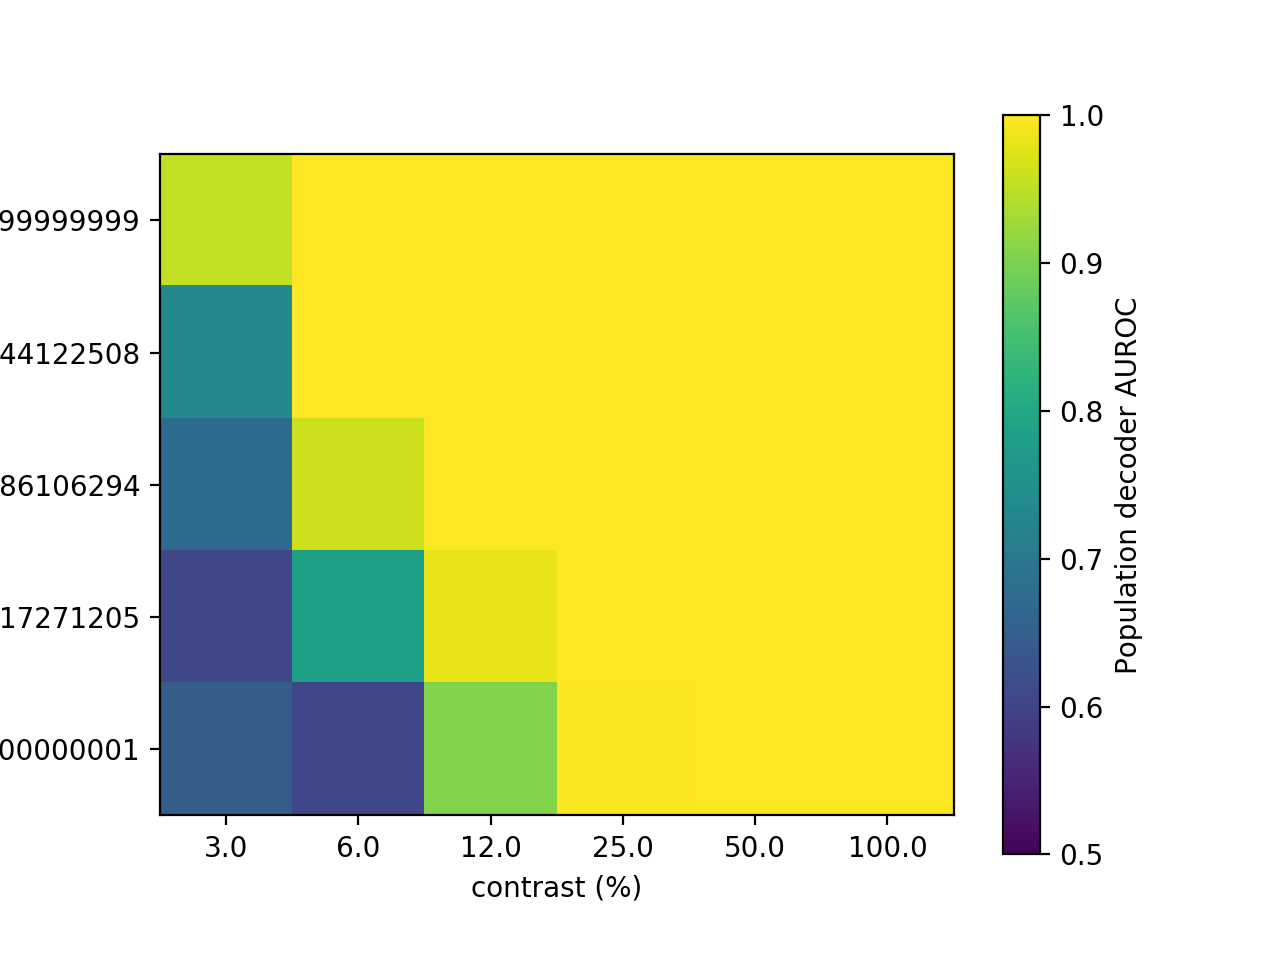

<IPython.core.display.Javascript object>


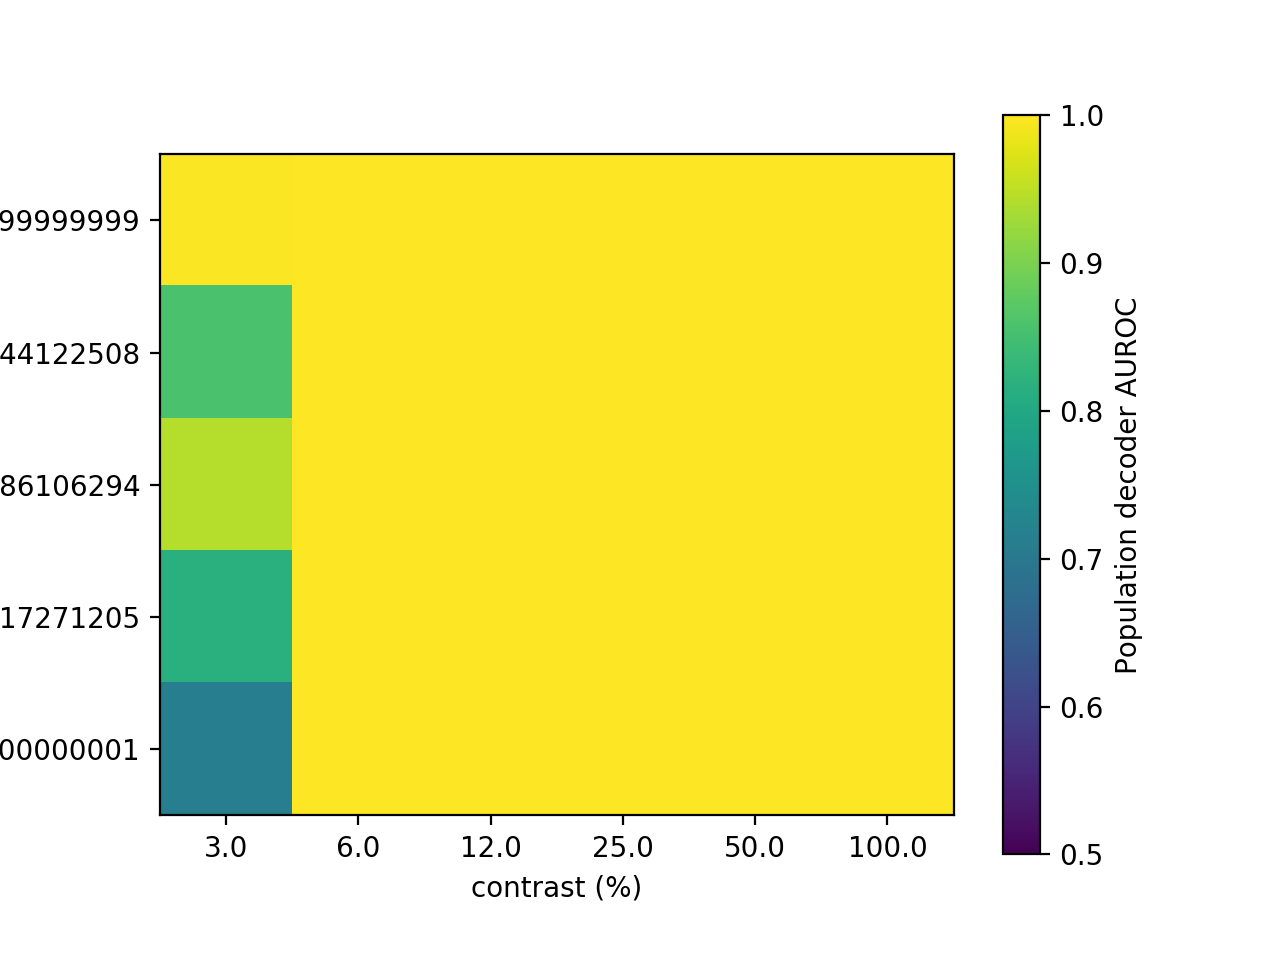

<IPython.core.display.Javascript object>


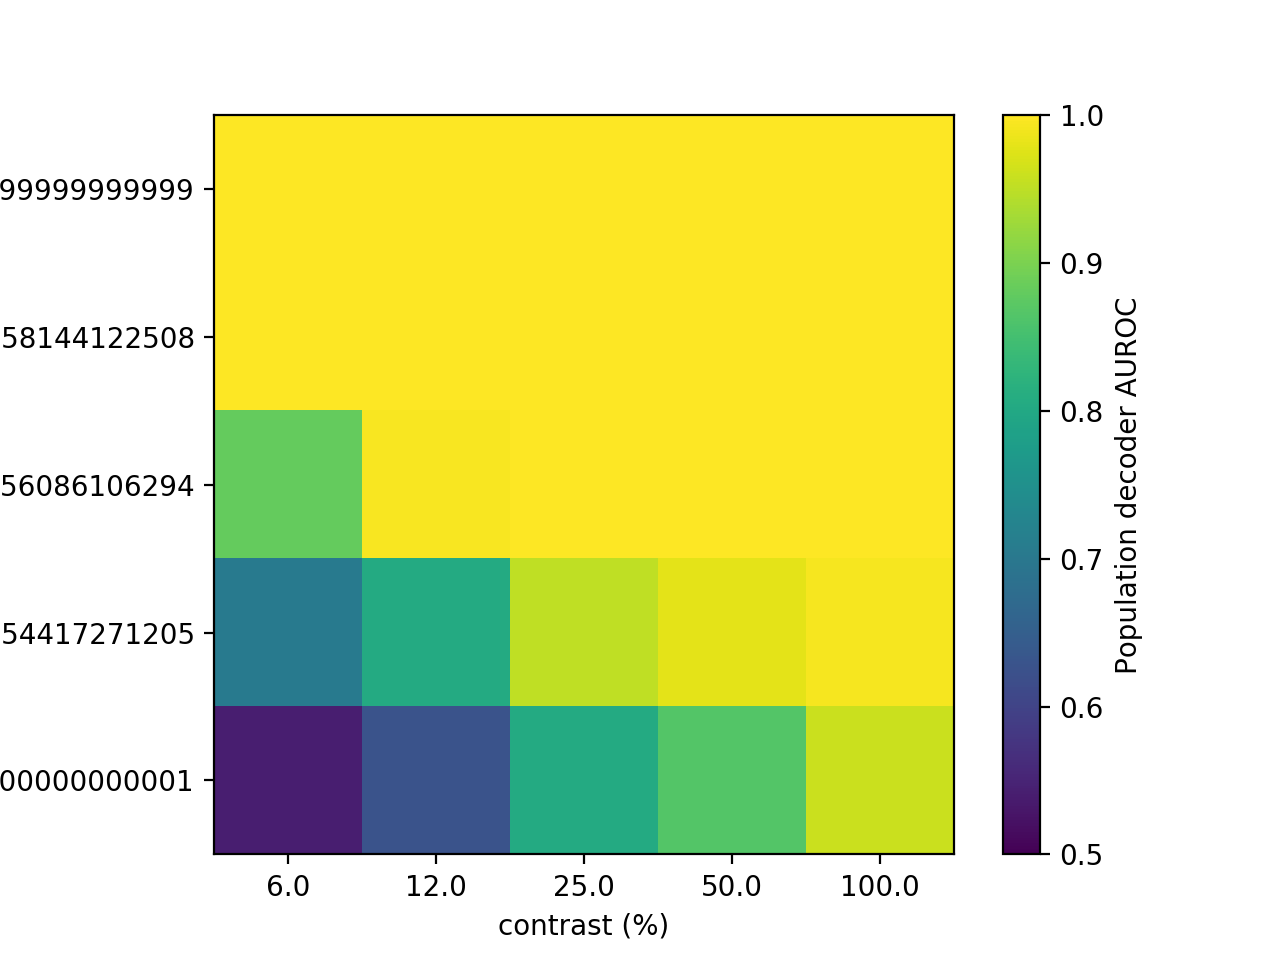

<IPython.core.display.Javascript object>


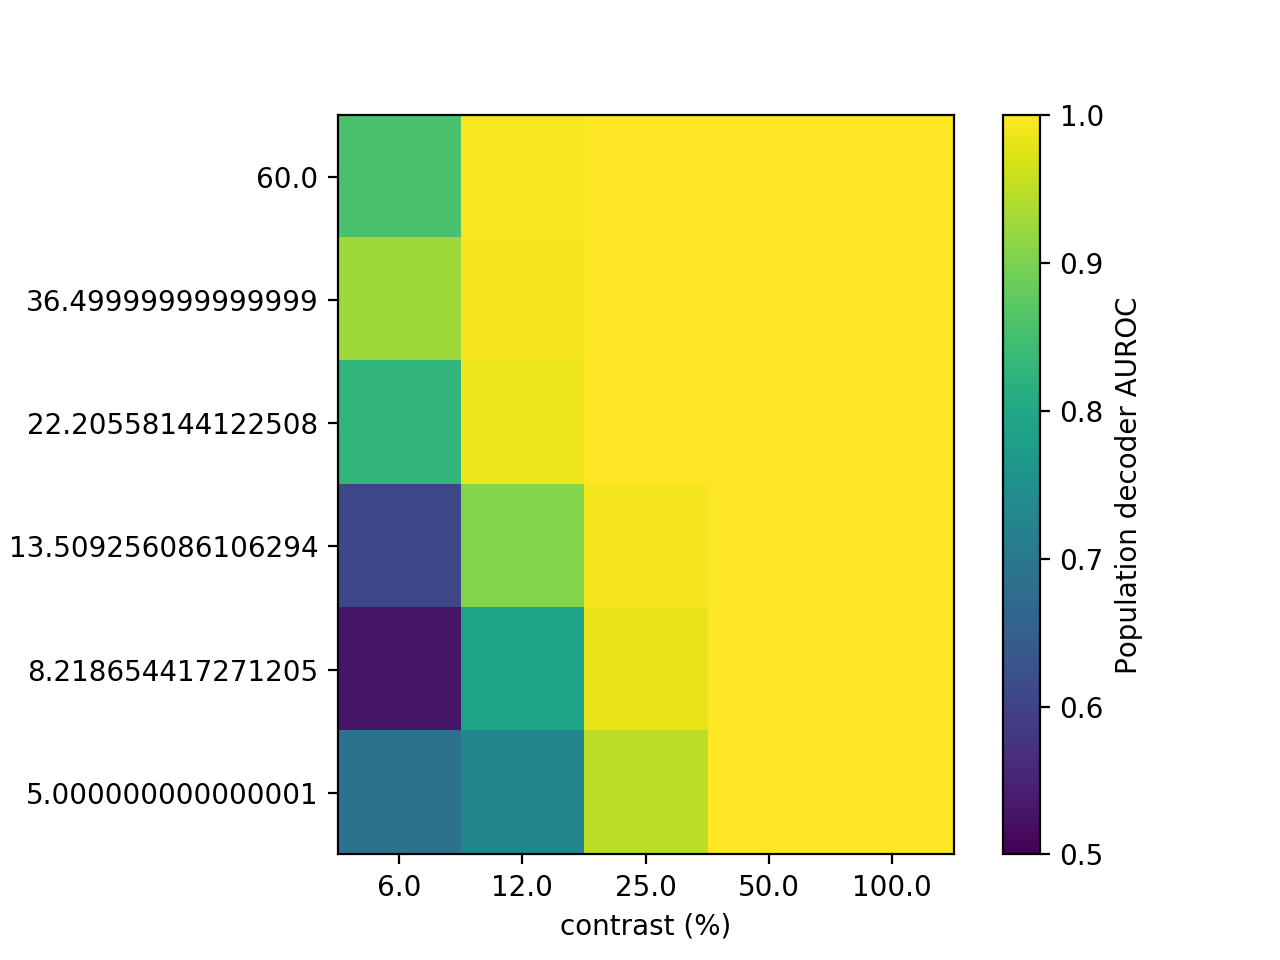

<IPython.core.display.Javascript object>


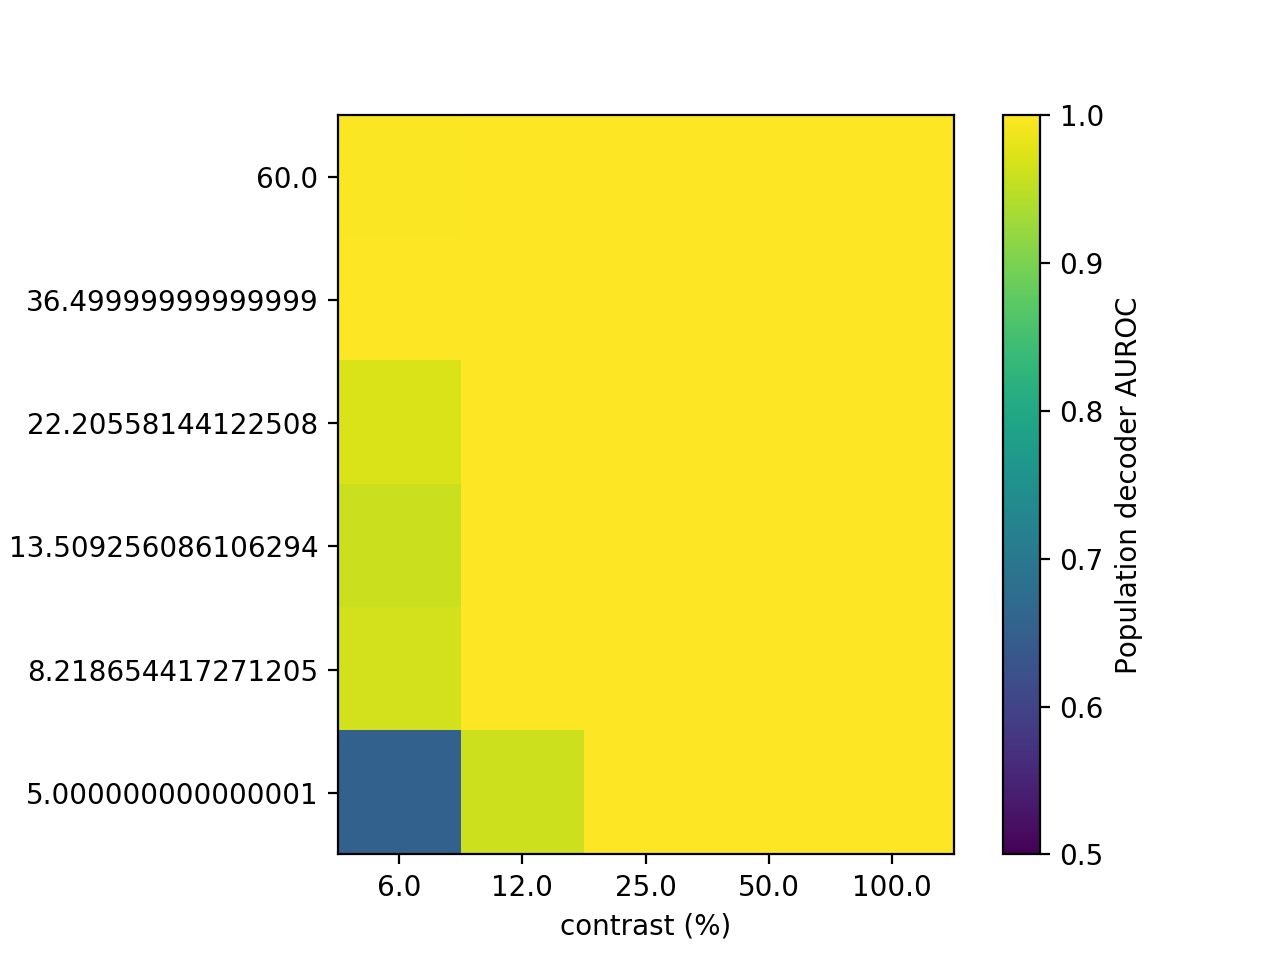

In [125]:
for iexpt in range(len(keylist)):
    if not auroc[iexpt] is None:
        plt.figure()
        sca.show_size_contrast(np.nanmean(auroc[iexpt][:,1:],-1),flipud=True,usize=usize[iexpt],ucontrast=100*ucontrast[iexpt][1:])
        plt.colorbar().set_label('Population decoder AUROC')
        plt.clim([0.5,1])

In [ ]:
nkey = len(keylist)
nangle = 8
R = [None for k in range(nkey)]
reg = [None for k in range(nkey)]
top_score = [None]*nkey
cutoffs = np.round(np.arange(20,21)).astype('int')
# cutoffs = (50,)
proc = [{} for k in range(len(keylist))]
with ut.hdf5read(dsname) as ds:
    for k in range(len(keylist)):
        print(keylist[k])
        R[k] = [None for icutoff in range(len(cutoffs))]
        reg[k] = [None for icutoff in range(len(cutoffs))]
        sc0 = ds[keylist[k]]['size_contrast_0']
        decon = np.nanmean(sc0['decon'][()][:,:,nbefore:-nafter],-1)
        data = sst.zscore(decon,axis=1)
        data[np.isnan(data)] = 0

        u,sigma,v = np.linalg.svd(data)

        pval_ret = sc0['rf_mapping_pval'][()]
        dist_ret = sc0['rf_distance_deg'][()]
        ontarget_ret_lax = np.logical_and(dist_ret<40,pval_ret<0.05)
        running_speed_cm_s = sc0['running_speed_cm_s'][()]
        running = np.nanmean(running_speed_cm_s[:,nbefore:-nafter],1)>7
        size = sc0['stimulus_id'][()][0]
        contrast = sc0['stimulus_id'][()][1]
        angle = sc0['stimulus_id'][()][-1]

        proc[k]['u'] = u
        proc[k]['sigma'] = sigma
        proc[k]['v'] = v  
        proc[k]['pval_ret'] = pval_ret
        proc[k]['dist_ret'] = dist_ret
        proc[k]['ontarget_ret_lax'] = ontarget_ret_lax
        proc[k]['running_speed_cm_s'] = running_speed_cm_s
        proc[k]['running'] = running
        proc[k]['size'] = size
        proc[k]['contrast'] = contrast
        proc[k]['angle'] = angle
        
        uangle,usize,ucontrast = [sc0[key][()] for key in ['stimulus_direction_deg','stimulus_size_deg','stimulus_contrast']]
        
        proc[k]['uangle'],proc[k]['usize'],proc[k]['ucontrast'] = uangle,usize,ucontrast

        if np.logical_and(ontarget_ret_lax.sum()>100,running.mean()>0.5):
            uangle,usize,ucontrast = [np.unique(arr) for arr in [angle,size,contrast]]
            nsize = len(usize)
            ncontrast = len(ucontrast)
            nangle = len(uangle)
            top_score[k] = np.zeros((len(cutoffs),nsize,nangle))
            for icutoff,cutoff in enumerate(cutoffs):
                R[k][icutoff] = np.zeros((nsize,nangle,cutoff))
                reg[k][icutoff] = [None for s in range(nsize)]
                plt.figure(figsize=(10,2))
                for s in range(nsize):
                    reg[k][icutoff][s] = [None for i in range(nangle)]
                    plt.subplot(1,nsize,s+1)
                    for i in range(nangle):
                        stim_of_interest_all_contrast = ut.k_and(np.logical_or(np.logical_and(angle==i,size==s),contrast==0),running) #,eye_dist < np.nanpercentile(eye_dist,50))
                        X = (np.diag(sigma[:cutoff]) @ v[:cutoff,:]).T[stim_of_interest_all_contrast]
#                         uangle = np.unique(angle)
                        y = contrast[stim_of_interest_all_contrast] #>0

                        na = 50
                        sc = np.zeros((na,))
                        alphas = np.logspace(-2,2,na)
                        for ia,alpha in enumerate(alphas):
                            linreg = sklearn.linear_model.Ridge(alpha=alpha,normalize=True)
                            reg1 = linreg.fit(X,y)
                            scores = sklearn.model_selection.cross_validate(linreg,X,y,cv=5)
                            pred = sklearn.model_selection.cross_val_predict(linreg,X,y,cv=5)
                            sc[ia] = scores['test_score'].mean()
                        best_alpha = np.argmax(sc)
                        top_score[k][icutoff,s,i] = sc.max()
                        print((s,cutoff,top_score[k][icutoff,s,i]))
                        linreg = sklearn.linear_model.Ridge(alpha=alphas[best_alpha],normalize=True)
                        reg[k][icutoff][s][i] = linreg.fit(X,y)

                        R[k][icutoff][s,i] = reg[k][icutoff][s][i].coef_
#                         intercept[k][icutoff][s,i]

                        Xall =  (np.diag(sigma[:cutoff]) @ v[:cutoff,:]).T[stim_of_interest_all_contrast]

                        ypred = reg[k][icutoff][s][i].predict(Xall)

                        yactual = contrast[stim_of_interest_all_contrast]

                        plt.scatter(yactual+1*np.linspace(0,1,yactual.size),ypred,s=5)

    #                 plt.plot(sc)
    #                 plt.ylim(-1,1)

<IPython.core.display.Javascript object>


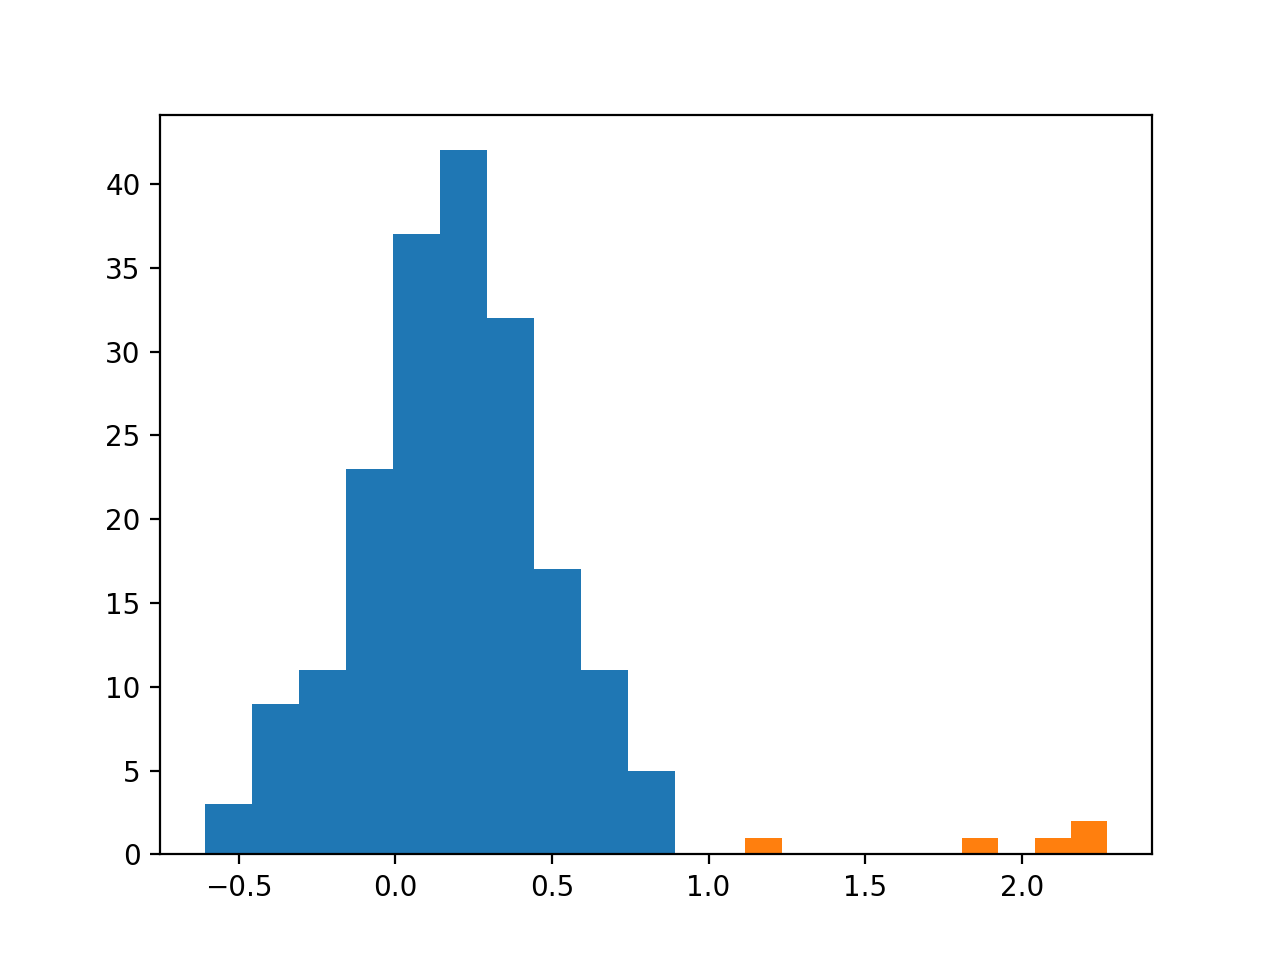

(array([1., 0., 0., 0., 0., 0., 1., 0., 1., 2.]),
 array([1.11778622, 1.23311798, 1.34844973, 1.46378149, 1.57911324,
        1.694445  , 1.80977675, 1.92510851, 2.04044026, 2.15577202,
        2.27110377]),
 <a list of 10 Patch objects>)

In [55]:
plt.figure()
plt.hist(y0)
plt.hist(y1)

/home/mossing/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2245: RuntimeWarning: invalid value encountered in true_divide
  np.expand_dims(sstd, axis=axis))
/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


<IPython.core.display.Javascript object>


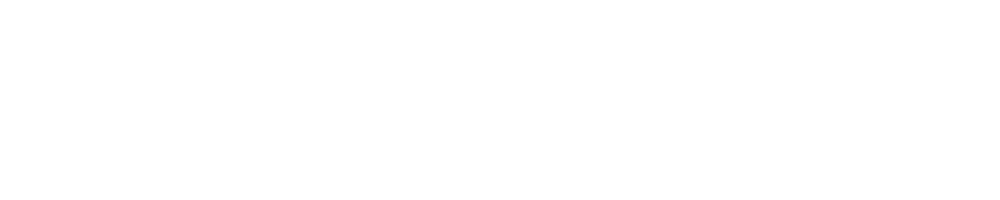

(0, 20, -0.006869282864011006)
(0, 20, -0.0088168915256309575)
(0, 20, -0.031266966344877169)
(0, 20, -0.025186604128747108)
(0, 20, 0.0021859904054418733)
(0, 20, -0.020106982559901843)
(0, 20, -0.10685961955875101)
(0, 20, 0.11374100643845297)
(1, 20, 0.34334779310797775)
(1, 20, -0.024784006455942361)
(1, 20, 0.25175585753656954)
(1, 20, -0.041666666666666664)
(1, 20, 0.041036632136681704)
(1, 20, 0.59559686799452638)
(1, 20, -0.010044375788353785)
(1, 20, 0.062317873986984185)
(2, 20, 0.4280254180550867)
(2, 20, 0.52724655972651002)
(2, 20, -0.34517550125433832)
(2, 20, -0.025506646538567823)
(2, 20, 0.80296369221611197)
(2, 20, 0.34642867230340163)
(2, 20, -0.072431522014253777)
(2, 20, 0.49523173992914704)
(3, 20, 0.76795946493204037)
(3, 20, 0.71548539519460974)
(3, 20, 0.79221792793948198)
(3, 20, 0.86729167854800304)
(3, 20, 0.89309057216860355)
(3, 20, 0.80223064200516259)
(3, 20, 0.58926436832336948)
(3, 20, 0.86760662142591682)
(4, 20, 0.75067560520670895)
(4, 20, 0.9328988

In [153]:
nkey = len(keylist)
nangle = 8
Rlow = [None]*nkey
top_score = [None]*nkey
cutoffs = np.round(np.arange(20,21)).astype('int')

eye_cutoff = 50

# cutoffs = (50,)
for k in (1,): #range(len(keylist)):
    Rlow[k] = [None]*len(cutoffs)
    data = sst.zscore(ds[keylist[k]]['decon'][()],axis=1)
    data[np.isnan(data)] = 0
    
    u,sigma,v = np.linalg.svd(data)
    
    pval_ret = ds[keylist[k]]['rf_mapping_pval'][()]
    dist_ret = ds[keylist[k]]['rf_distance_deg'][()]
    ontarget_ret_lax = np.logical_and(dist_ret<40,pval_ret<0.05)
    running_speed_cm_s = ds[keylist[k]]['running_speed_cm_s'][()]
    running = running_speed_cm_s>7
    size = ds[keylist[k]]['stimulus_id'][()][0]
    contrast = ds[keylist[k]]['stimulus_id'][()][1]
    angle = ds[keylist[k]]['stimulus_id'][()][-1]
    
    proc[k]['u'] = u
    proc[k]['sigma'] = sigma
    proc[k]['v'] = v  
    proc[k]['pval_ret'] = pval_ret
    proc[k]['dist_ret'] = dist_ret
    proc[k]['ontarget_ret_lax'] = ontarget_ret_lax
    proc[k]['running_speed_cm_s'] = running_speed_cm_s
    proc[k]['running'] = running
    proc[k]['size'] = size
    proc[k]['contrast'] = contrast
    proc[k]['angle'] = angle
    
    if np.logical_and(ontarget_ret_lax.sum()>100,running.mean()>0.5):
        top_score[k] = np.zeros((len(cutoffs),5,8))
        for icutoff,cutoff in enumerate(cutoffs):
            Rlow[k][icutoff] = np.zeros((5,8,cutoff))
            plt.figure(figsize=(10,2))
            for s in range(5):
                plt.subplot(1,5,s+1)
                for i in range(nangle):
                    stim_of_interest_all_contrast = k_and(np.logical_or(k_and(angle==i,size==s,contrast<4),contrast==0),running,eye_dist < np.nanpercentile(eye_dist,eye_cutoff))
                    X = (np.diag(sigma[:cutoff]) @ v[:cutoff,:]).T[stim_of_interest_all_contrast]
                    uangle = np.unique(angle)
                    y = contrast[stim_of_interest_all_contrast] #>0

                    na = 50
                    sc = np.zeros((na,))
                    alphas = np.logspace(-2,2,na)
                    for ia,alpha in enumerate(alphas):
                        linreg = sklearn.linear_model.Ridge(alpha=alpha,normalize=True)
                        reg = linreg.fit(X,y)
                        scores = sklearn.model_selection.cross_validate(linreg,X,y)
                        pred = sklearn.model_selection.cross_val_predict(linreg,X,y)
                        sc[ia] = scores['test_score'].mean()
                    best_alpha = np.argmax(sc)
                    top_score[k][icutoff,s,i] = sc.max()
                    print((s,cutoff,top_score[k][icutoff,s,i]))
                    linreg = sklearn.linear_model.Ridge(alpha=alphas[best_alpha],normalize=True)
                    reg = linreg.fit(X,y)

                    Rlow[k][icutoff][s,i] = reg.coef_

                    Xall =  (np.diag(sigma[:cutoff]) @ v[:cutoff,:]).T[stim_of_interest_all_contrast]

                    ypred = reg.predict(Xall)

                    yactual = contrast[stim_of_interest_all_contrast]

                    plt.scatter(yactual+1*np.linspace(0,1,yactual.size),ypred,s=5)
                
#                 plt.plot(sc)
#                 plt.ylim(-1,1)

/home/mossing/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2245: RuntimeWarning: invalid value encountered in true_divide
  np.expand_dims(sstd, axis=axis))
/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


<IPython.core.display.Javascript object>


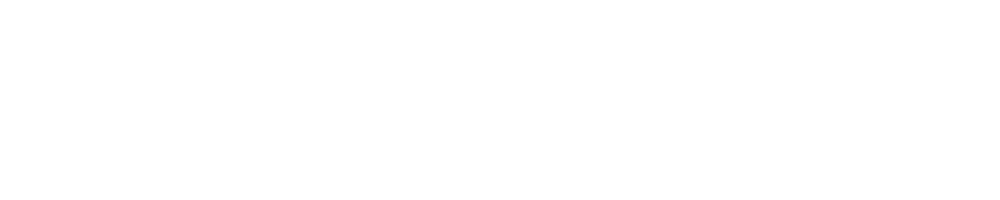

(0, 20, -0.78886688495249613)
(0, 20, -1.8421434764866149)
(0, 20, -0.48467854293033791)
(0, 20, 0.43996105359042242)
(0, 20, 0.53441550820487016)
(0, 20, 0.2383120883588791)
(0, 20, 0.75705843306139631)
(0, 20, 0.37474130525393057)
(1, 20, 0.5523772587179091)
(1, 20, 0.55298992294749194)
(1, 20, 0.66654196030152113)
(1, 20, -0.18224926911148173)
(1, 20, 0.6760055921844178)
(1, 20, 0.29419030535567742)
(1, 20, 0.30494195426464366)
(1, 20, 0.0)
(2, 20, -1.9776474233805637)
(2, 20, 0.66338913414745615)
(2, 20, 0.62468519529445621)
(2, 20, 0.62984590650015948)
(2, 20, 0.085063347918843471)
(2, 20, 0.78359278776674512)
(2, 20, 0.84505021546575598)
(2, 20, 0.29432856439747007)
(3, 20, 0.46094189562465182)
(3, 20, 0.38956460168705592)
(3, 20, -0.2440876842027363)
(3, 20, 0.75863058677858308)
(3, 20, 0.90861501968507385)
(3, 20, 0.67317163652951162)
(3, 20, 0.44121869687325427)
(3, 20, -0.16536180359296251)
(4, 20, 0.79286094458762146)
(4, 20, 0.92233191075559873)
(4, 20, 0.4606254012716659)


In [154]:
nkey = len(keylist)
nangle = 8
Rhigh = [None]*nkey
top_score = [None]*nkey
cutoffs = np.round(np.arange(20,21)).astype('int')

eye_cutoff = 50

# cutoffs = (50,)
for k in (1,): #range(len(keylist)):
    Rhigh[k] = [None]*len(cutoffs)
    data = sst.zscore(ds[keylist[k]]['decon'][()],axis=1)
    data[np.isnan(data)] = 0
    
    u,sigma,v = np.linalg.svd(data)
    
    pval_ret = ds[keylist[k]]['rf_mapping_pval'][()]
    dist_ret = ds[keylist[k]]['rf_distance_deg'][()]
    ontarget_ret_lax = np.logical_and(dist_ret<40,pval_ret<0.05)
    running_speed_cm_s = ds[keylist[k]]['running_speed_cm_s'][()]
    running = running_speed_cm_s>7
    size = ds[keylist[k]]['stimulus_id'][()][0]
    contrast = ds[keylist[k]]['stimulus_id'][()][1]
    angle = ds[keylist[k]]['stimulus_id'][()][-1]
    
    proc[k]['u'] = u
    proc[k]['sigma'] = sigma
    proc[k]['v'] = v  
    proc[k]['pval_ret'] = pval_ret
    proc[k]['dist_ret'] = dist_ret
    proc[k]['ontarget_ret_lax'] = ontarget_ret_lax
    proc[k]['running_speed_cm_s'] = running_speed_cm_s
    proc[k]['running'] = running
    proc[k]['size'] = size
    proc[k]['contrast'] = contrast
    proc[k]['angle'] = angle
    
    if np.logical_and(ontarget_ret_lax.sum()>100,running.mean()>0.5):
        top_score[k] = np.zeros((len(cutoffs),5,8))
        for icutoff,cutoff in enumerate(cutoffs):
            Rhigh[k][icutoff] = np.zeros((5,8,cutoff))
            plt.figure(figsize=(10,2))
            for s in range(5):
                plt.subplot(1,5,s+1)
                for i in range(nangle):
                    stim_of_interest_all_contrast = k_and(angle==i,size==s,contrast>=4,running,eye_dist < np.nanpercentile(eye_dist,eye_cutoff))
                    X = (np.diag(sigma[:cutoff]) @ v[:cutoff,:]).T[stim_of_interest_all_contrast]
                    uangle = np.unique(angle)
                    y = contrast[stim_of_interest_all_contrast] #>0

                    na = 50
                    sc = np.zeros((na,))
                    alphas = np.logspace(-2,2,na)
                    for ia,alpha in enumerate(alphas):
                        linreg = sklearn.linear_model.Ridge(alpha=alpha,normalize=True)
                        reg = linreg.fit(X,y)
                        scores = sklearn.model_selection.cross_validate(linreg,X,y)
                        pred = sklearn.model_selection.cross_val_predict(linreg,X,y)
                        sc[ia] = scores['test_score'].mean()
                    best_alpha = np.argmax(sc)
                    top_score[k][icutoff,s,i] = sc.max()
                    print((s,cutoff,top_score[k][icutoff,s,i]))
                    linreg = sklearn.linear_model.Ridge(alpha=alphas[best_alpha],normalize=True)
                    reg = linreg.fit(X,y)

                    Rhigh[k][icutoff][s,i] = reg.coef_

                    Xall =  (np.diag(sigma[:cutoff]) @ v[:cutoff,:]).T[stim_of_interest_all_contrast]

                    ypred = reg.predict(Xall)

                    yactual = contrast[stim_of_interest_all_contrast]

                    plt.scatter(yactual+1*np.linspace(0,1,yactual.size),ypred,s=5)
                
#                 plt.plot(sc)
#                 plt.ylim(-1,1)

In [155]:
# plt.figure(figsize=(16,2))
for k in range(len(top_score)):
#     plt.subplot(1,len(top_score),k+1)
    if not top_score[k] is None:
#         plt.plot(top_score[k].mean(-1))
        print(str(k)+': '+str(top_score[k].mean(-1)))
#         plt.ylim((0,1))

1: [[-0.09640006  0.35809972  0.24353847  0.40283662  0.56757575]]


In [134]:
# np.save('all_ridge_regression_coefficients.npy',{'R':R})

In [142]:
def dot_product(v1,v2):
    return (v1*v2).sum()/np.sqrt((v1**2).sum())/np.sqrt((v2**2).sum())
dp = np.ones((nkey,nsize,nangle,nangle))*np.nan
for k in range(nkey):
    if not R[k] is None:
        for s in range(5):
            for i in range(nangle):
                for j in range(nangle):
                    dp[k,s,i,j] = dot_product(R[k][0][s,i],R[k][0][s,j])

In [137]:
fig = plt.figure()
ax = fig.add_subplot(111)
c = -1
k = 2
for s in range(5):
    ax.scatter(R[k][c][s,:,0],R[k][c][s,:,1])

<IPython.core.display.Javascript object>

TypeError: 'NoneType' object is not subscriptable

<IPython.core.display.Javascript object>


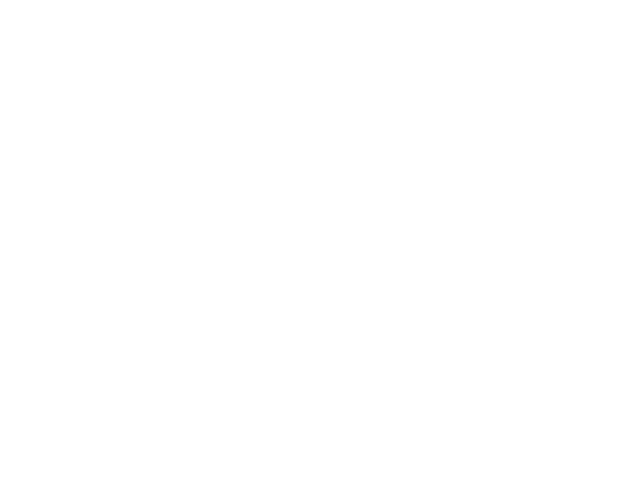

In [138]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
for s in range(5):
    ax.scatter(R[1][c][s,:,0],R[1][c][s,:,1],R[1][c][s,:,2])

<IPython.core.display.Javascript object>


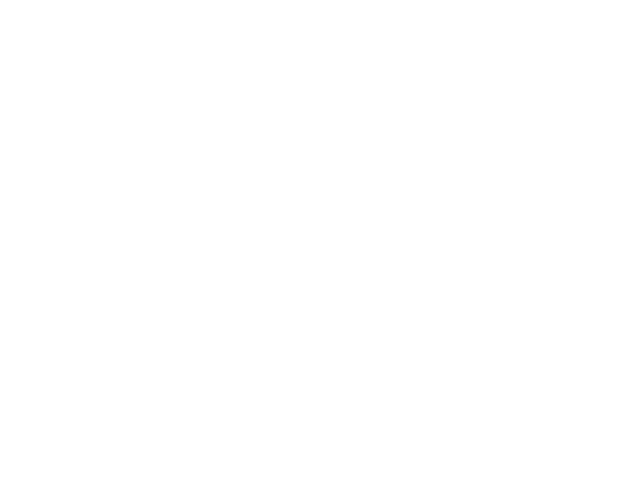

In [139]:
plt.figure()
for s in range(5):
    plt.plot(np.abs(R[1][c][s].mean(0))[:10])

<IPython.core.display.Javascript object>


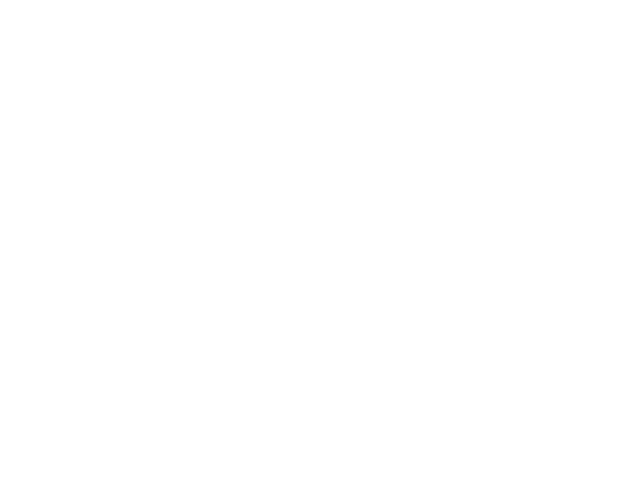

ValueError: Scalar operands are not allowed, use '*' instead

In [140]:
plt.figure()
for i in range(nangle):
    plt.plot(u[:,:cutoffs[c]] @ R[1][c][0,i][0])

<IPython.core.display.Javascript object>


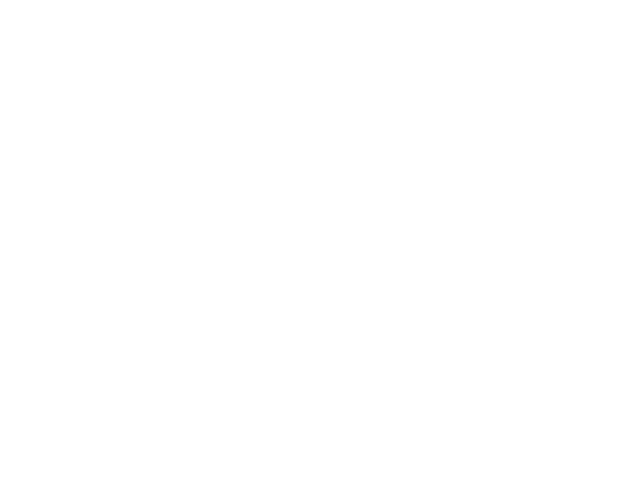

In [143]:
plt.figure()
for s in range(5):
    plt.subplot(1,5,s+1)
    plt.imshow(dp[1,s],vmin=0,vmax=1)

In [214]:
plt.close('all')

<IPython.core.display.Javascript object>


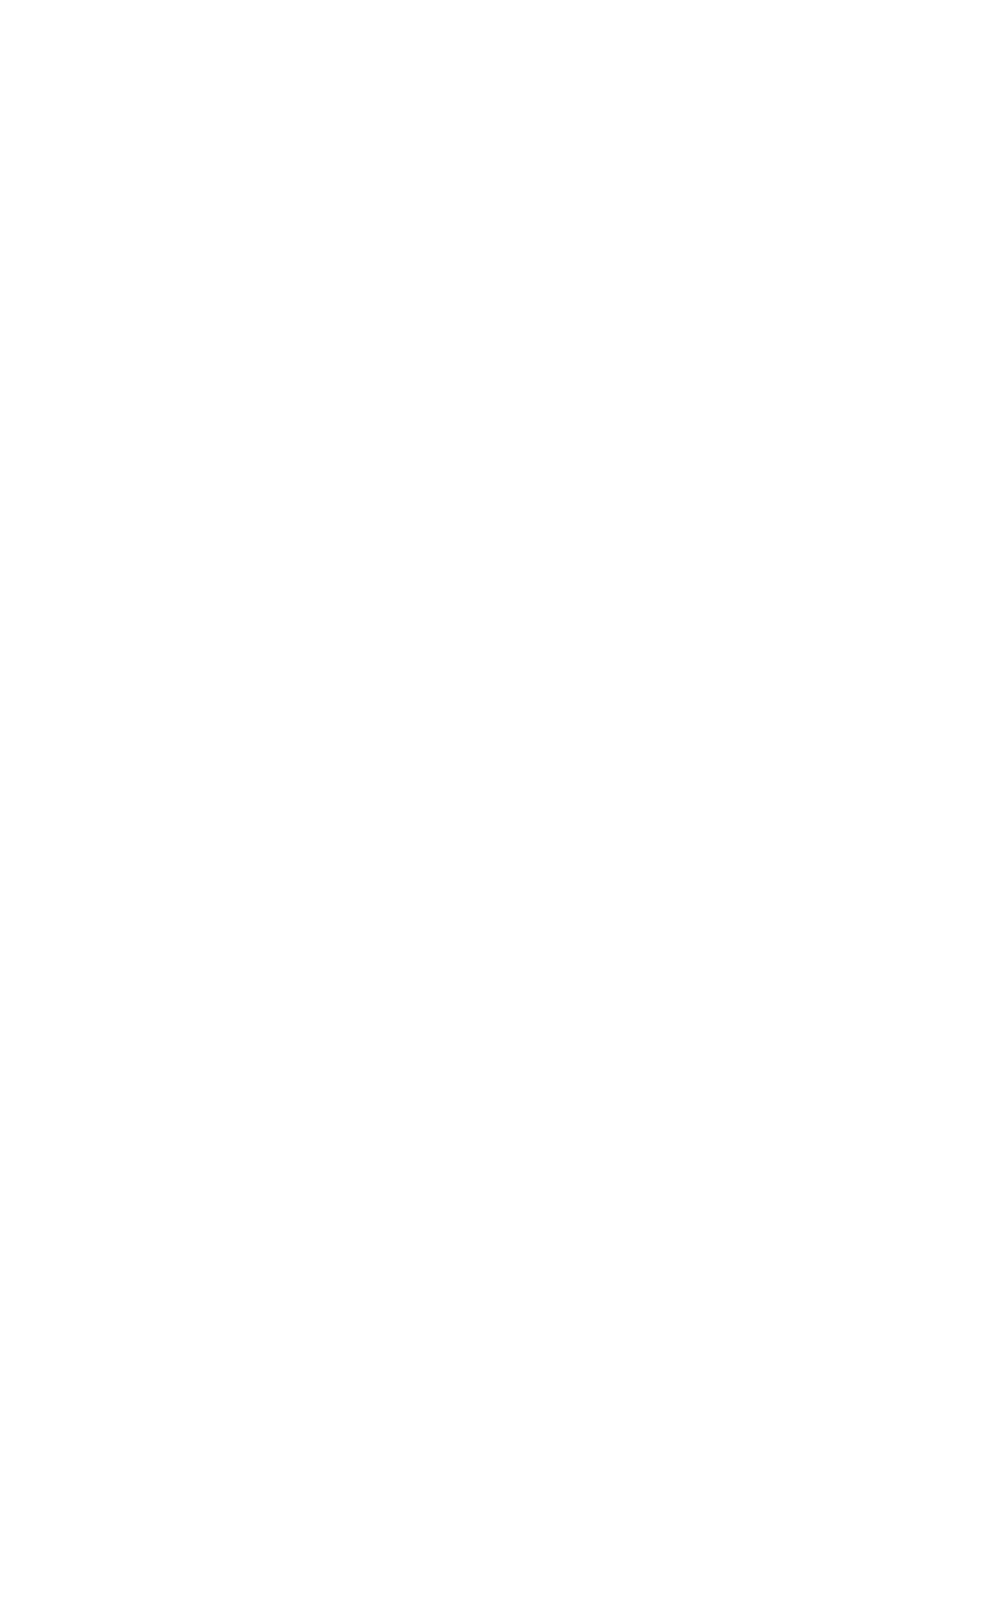

In [145]:
k = 1

size = proc[k]['size']
contrast = proc[k]['contrast']
angle = proc[k]['angle']
v = proc[k]['v']

c = -1
s = 0
a = 0
x = (0.5*(R[k][c][s,a] + R[k][c][s,a+4]) @ v[:cutoffs[c]])
s = 0
a = 2
y = (0.5*(R[k][c][s,a] + R[k][c][s,a+4]) @ v[:cutoffs[c]])

fig = plt.figure(figsize=(10,16))
for s in range(5):
    for a in range(8):
        ax = plt.subplot(8,5,a*5+s+1)#,projection='3d')
#         ax.view_init(0, 45)
        for c in range(6):
            lkat = k_and(contrast==c,size==s,angle==a)
            ax.scatter(x[lkat],y[lkat])#,z[lkat])
        ax.set_xlim(-0.03,0.03)
        ax.set_ylim(-0.03,0.03)

<IPython.core.display.Javascript object>


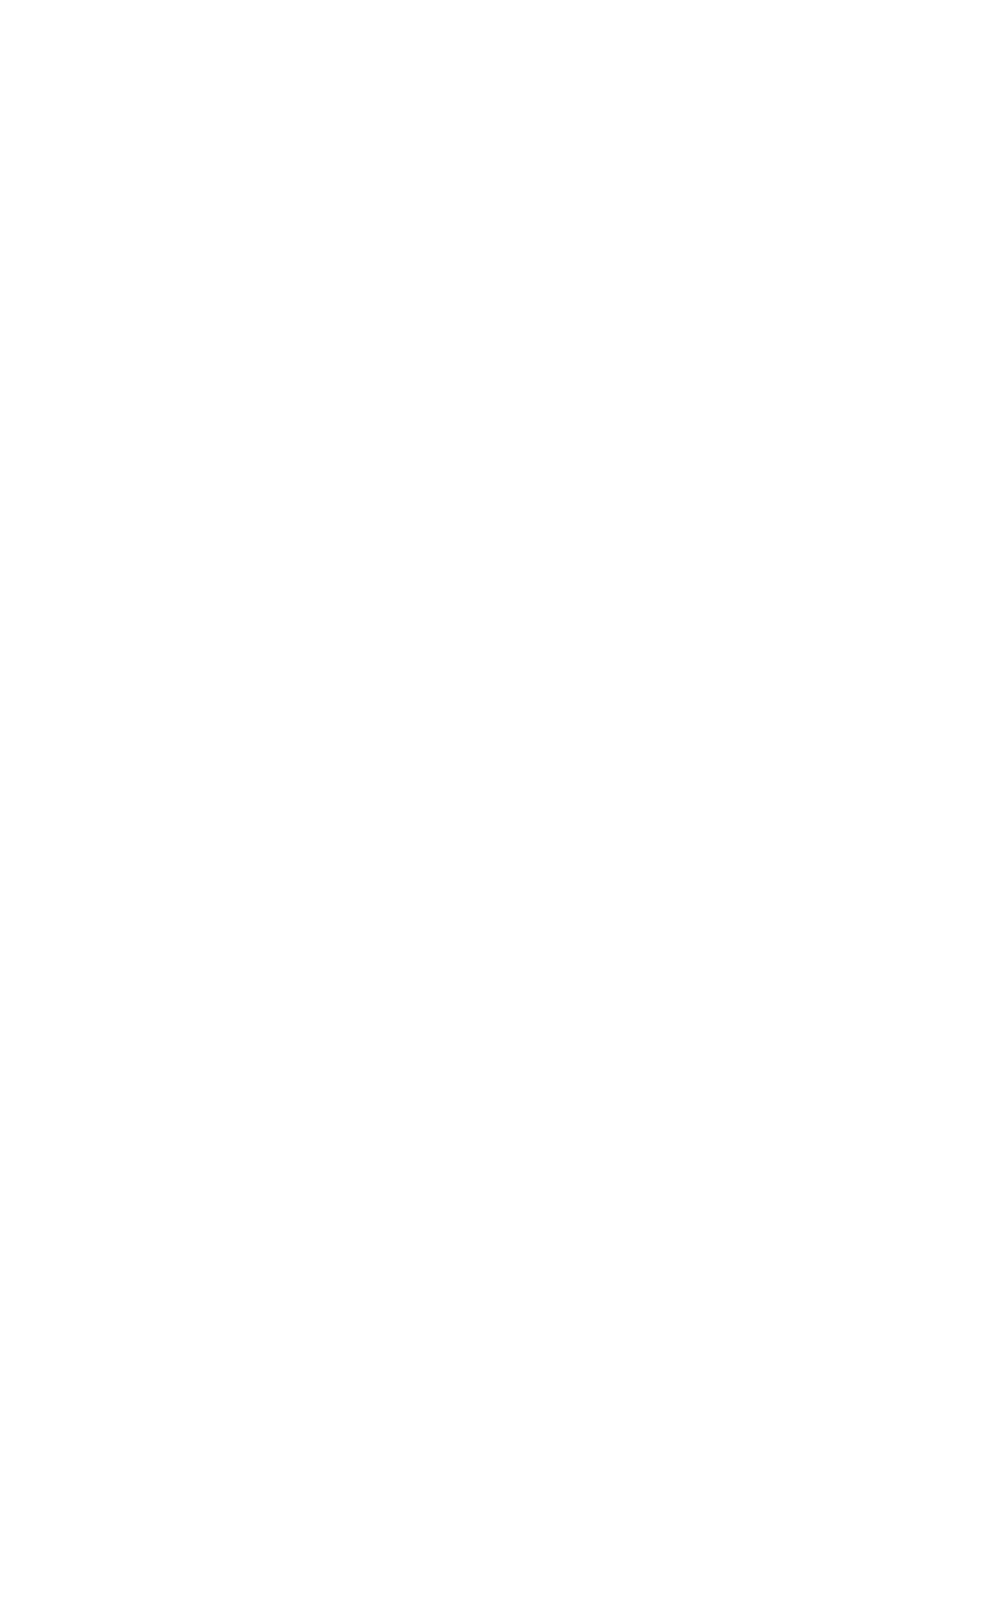

In [146]:
c = 0
s = -1
a = 0
x = (0.5*(R[k][c][s,a] + R[k][c][s,a+4]) @ v[:cutoffs[c]])
s = -1
a = 2
y = (0.5*(R[k][c][s,a] + R[k][c][s,a+4]) @ v[:cutoffs[c]])

fig = plt.figure(figsize=(10,16))
for s in range(5):
    for a in range(8):
        ax = plt.subplot(8,5,a*5+s+1)#,projection='3d')
#         ax.view_init(0, 45)
        for c in range(6):
            lkat = k_and(contrast==c,size==s,angle==a)
            ax.scatter(x[lkat],y[lkat])#,z[lkat])
        ax.set_xlim(-0.04,0.04)
        ax.set_ylim(-0.04,0.04)

<IPython.core.display.Javascript object>


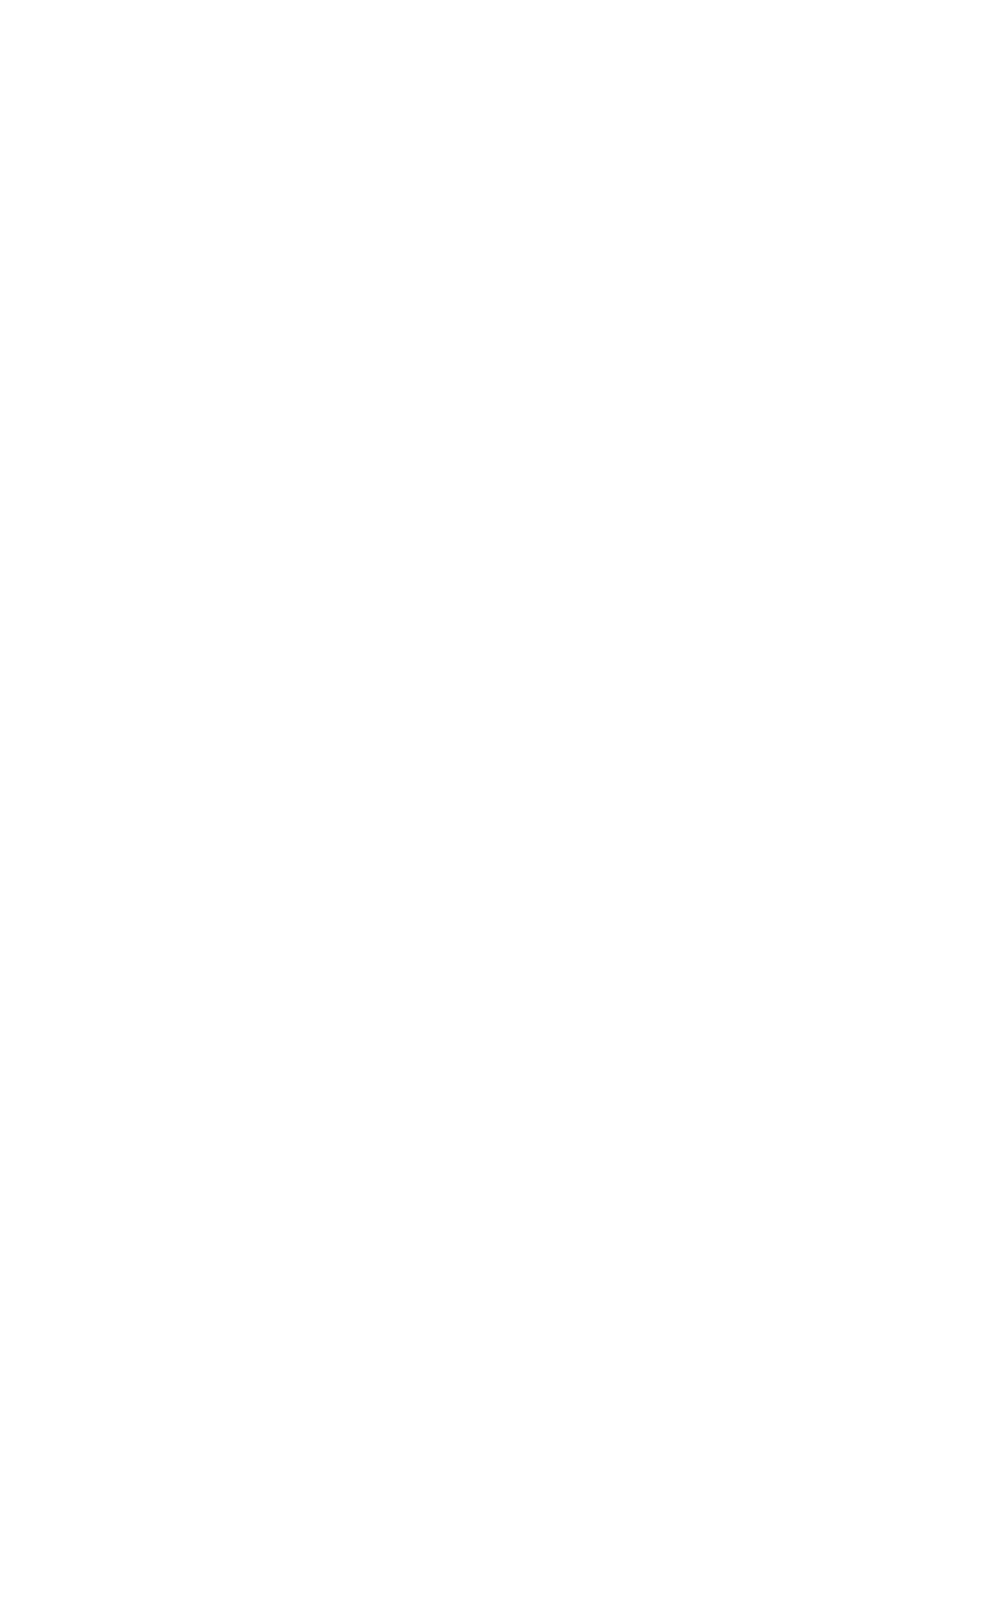

In [151]:
for k in (1,): #2,7):
    colors = plt.cm.viridis(np.linspace(0,1,6))

    v = proc[k]['v']
    contrast = proc[k]['contrast']
    size = proc[k]['size']
    angle = proc[k]['angle']

    icutoff = 0

    s = -1
    a = 0
    x = (R[k][icutoff][s,:].mean(0) @ v[:cutoffs[icutoff]])

    s = -1
    a = 2
    y = (0.5*(R[k][icutoff][s,a] + R[k][icutoff][s,a+4]) @ v[:cutoffs[icutoff]])

    s = 0
    a = 2
    z = (0.5*(R[k][icutoff][s,a] + R[k][icutoff][s,a+4]) @ v[:cutoffs[icutoff]])

    fig = plt.figure(figsize=(10,16))
    for a in range(8):
        s = -1
        y = (R[k][icutoff][s,a] @ v[:cutoffs[icutoff]])
        for s in range(5):
#             y = (R[k][icutoff][s,a] @ v[:cutoffs[icutoff]])
            ax = plt.subplot(8,5,a*5+s+1) #,projection='3d')
    #         ax.view_init(0, 0)
            for c in range(6):
                lkat = k_and(contrast==c,size==s,angle==a)
                ax.scatter(y[lkat],z[lkat],s=5,c=colors[c],alpha=0.2)
                ax.scatter(y[lkat].mean(),z[lkat].mean(),s=25,c=colors[c])
    #         ax.set_xlim(-0.03,0.03)
    #         ax.set_ylim(-0.03,0.03)
    #         ax.set_zlim(-0.03,0.03)

<IPython.core.display.Javascript object>


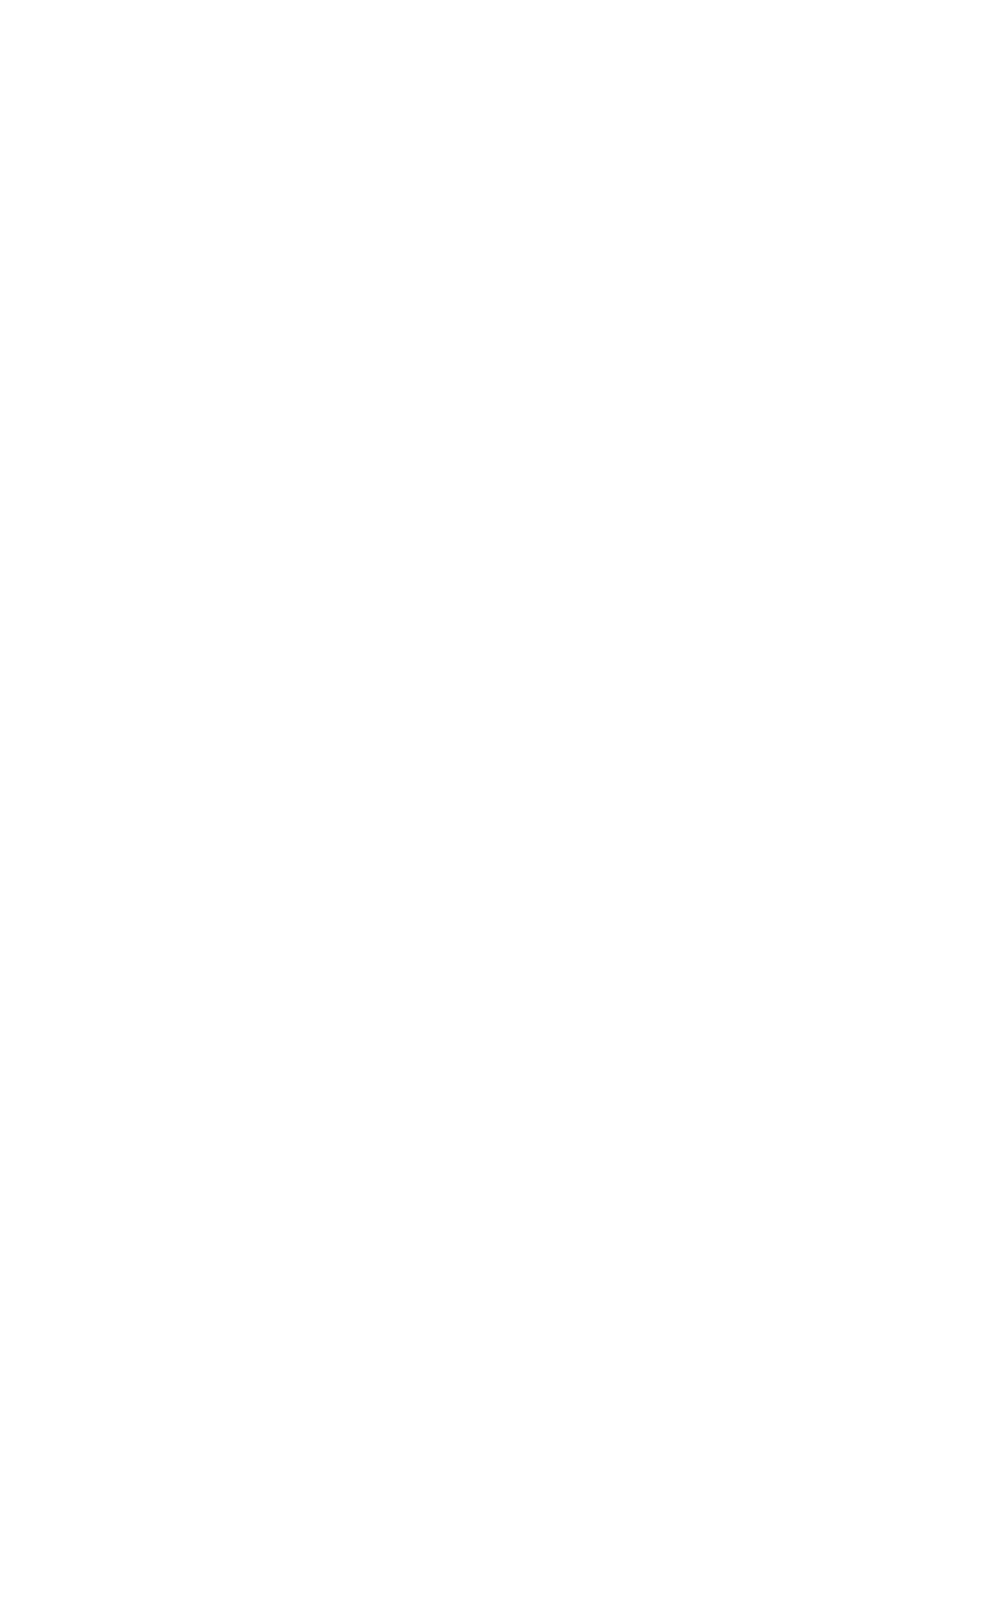

/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice.
/home/mossing/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [158]:
# x axis: low contrast coding dimension
# y axis: high contrast coding dimension
# by size and angle
for k in (1,): #2,7):
    colors = plt.cm.viridis(np.linspace(0,1,6))

    v = proc[k]['v']
    contrast = proc[k]['contrast']
    size = proc[k]['size']
    angle = proc[k]['angle']

    icutoff = 0

    s = -1
    a = 0
    x = (R[k][icutoff][s,:].mean(0) @ v[:cutoffs[icutoff]])

    s = -1
    a = 2
    y = (0.5*(R[k][icutoff][s,a] + R[k][icutoff][s,a+4]) @ v[:cutoffs[icutoff]])

    s = 0
    a = 2
    z = (0.5*(R[k][icutoff][s,a] + R[k][icutoff][s,a+4]) @ v[:cutoffs[icutoff]])

    fig = plt.figure(figsize=(10,16))
    for a in range(8):
        s = -1
        for s in range(5):
#             y = (R[k][icutoff][s,a] @ v[:cutoffs[icutoff]])
            y = (Rlow[k][icutoff][s,a] @ v[:cutoffs[icutoff]])
            z = (Rhigh[k][icutoff][s,a] @ v[:cutoffs[icutoff]])
            ax = plt.subplot(8,5,a*5+s+1) #,projection='3d')
    #         ax.view_init(0, 0)
            for c in range(6):
                lkat = k_and(contrast==c,size==s,angle==a,running,eye_dist<np.nanpercentile(eye_dist,eye_cutoff))
                ax.scatter(y[lkat],z[lkat],s=5,c=colors[c],alpha=0.2)
                ax.scatter(y[lkat].mean(),z[lkat].mean(),s=25,c=colors[c])
    #         ax.set_xlim(-0.03,0.03)
    #         ax.set_ylim(-0.03,0.03)
    #         ax.set_zlim(-0.03,0.03)

<IPython.core.display.Javascript object>


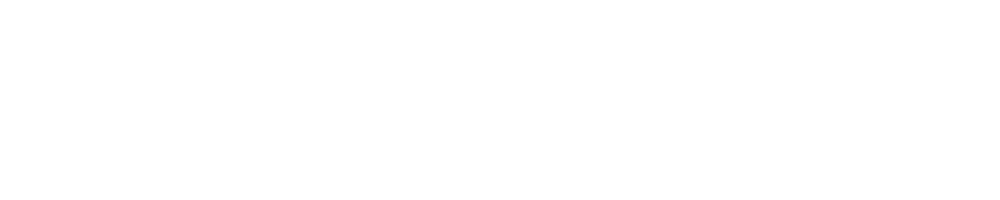

In [177]:
    # x axis: low contrast coding dimension
    # y axis: high contrast coding dimension
    # by size and angle
    for k in (1,): #2,7):
        colors = plt.cm.viridis(np.linspace(0,1,6))

        v = proc[k]['v']
        contrast = proc[k]['contrast']
        size = proc[k]['size']
        angle = proc[k]['angle']

        icutoff = 0

        s = -1
        a = 0
        x = (R[k][icutoff][s,:].mean(0) @ v[:cutoffs[icutoff]])

        s = -1
        a = 2
        y = (0.5*(R[k][icutoff][s,a] + R[k][icutoff][s,a+4]) @ v[:cutoffs[icutoff]])

        s = 0
        a = 2
        z = (0.5*(R[k][icutoff][s,a] + R[k][icutoff][s,a+4]) @ v[:cutoffs[icutoff]])

        fig = plt.figure(figsize=(10,2))
        s = -1
        
        whichangle = np.zeros((8,1400),dtype='bool')
        for i,theta in enumerate(angle):
            whichangle[theta,i] = 1
        
        for s in range(5):
#             y = (R[k][icutoff][s,a] @ v[:cutoffs[icutoff]])
            y = (Rlow[k][icutoff][s,:] @ v[:cutoffs[icutoff]]).mean(0)
            z = (Rhigh[k][icutoff][s,:] @ v[:cutoffs[icutoff]]).mean(0)
            ax = plt.subplot(1,5,s+1) #,projection='3d')
    #         ax.view_init(0, 0)
            for c in range(6):
                lkat = k_and(contrast==c,size==s,running,eye_dist<np.nanpercentile(eye_dist,eye_cutoff))
                ax.scatter(y[lkat],z[lkat],s=5,c=colors[c],alpha=0.5)
                ax.scatter(y[lkat].mean(),z[lkat].mean(),s=25,c=colors[c])

<IPython.core.display.Javascript object>


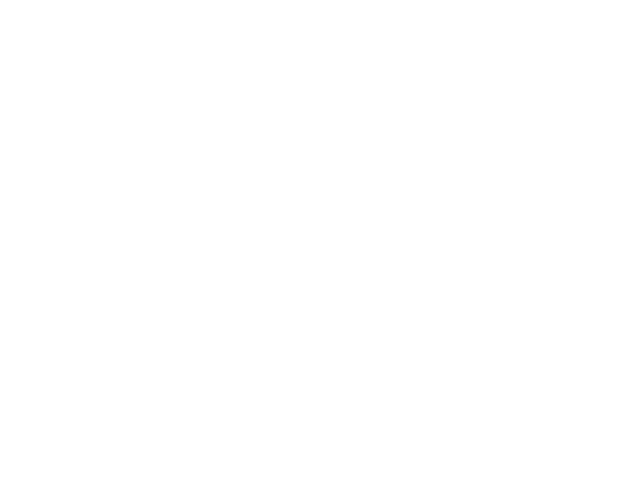

In [186]:
plt.figure()
plt.imshow((Rhigh[k][icutoff][s,:] @ v[:cutoffs[icutoff]])[:,k_and(contrast==5,s==4)])

In [179]:
(Rlow[k][icutoff][s,:] @ v[:cutoffs[icutoff]])[whichangle].shape

(1400,)

In [165]:
(Rlow[k][icutoff][s,:] @ v[:cutoffs[icutoff]]).shape

(8, 1400)

In [ ]:
nkey = len(keylist)
nangle = 8
R = [None]*nkey
top_score = [None]*nkey
cutoffs = np.round(np.arange(20,21)).astype('int')
# cutoffs = (50,)
for k in (1,): #range(len(keylist)):
    R[k] = [None]*len(cutoffs)
    data = sst.zscore(ds[keylist[k]]['decon'][()],axis=1)
    data[np.isnan(data)] = 0
    
    u,sigma,v = np.linalg.svd(data)
    
    pval_ret = ds[keylist[k]]['rf_mapping_pval'][()]
    dist_ret = ds[keylist[k]]['rf_distance_deg'][()]
    ontarget_ret_lax = np.logical_and(dist_ret<40,pval_ret<0.05)
    running_speed_cm_s = ds[keylist[k]]['running_speed_cm_s'][()]
    running = running_speed_cm_s>7
    size = ds[keylist[k]]['stimulus_id'][()][0]
    contrast = ds[keylist[k]]['stimulus_id'][()][1]
    angle = ds[keylist[k]]['stimulus_id'][()][-1]
    
    proc[k]['u'] = u
    proc[k]['sigma'] = sigma
    proc[k]['v'] = v  
    proc[k]['pval_ret'] = pval_ret
    proc[k]['dist_ret'] = dist_ret
    proc[k]['ontarget_ret_lax'] = ontarget_ret_lax
    proc[k]['running_speed_cm_s'] = running_speed_cm_s
    proc[k]['running'] = running
    proc[k]['size'] = size
    proc[k]['contrast'] = contrast
    proc[k]['angle'] = angle
    
    if np.logical_and(ontarget_ret_lax.sum()>100,running.mean()>0.5):
        top_score[k] = np.zeros((len(cutoffs),5,8))
        for icutoff,cutoff in enumerate(cutoffs):
            R[k][icutoff] = np.zeros((5,8,cutoff))
            plt.figure(figsize=(10,2))
            for s in range(5):
                plt.subplot(1,5,s+1)
                for i in range(nangle):
                    stim_of_interest_all_contrast = k_and(np.logical_or(np.logical_and(angle==i,size==s),contrast==0),running,eye_dist < np.nanpercentile(eye_dist,50))
                    X = (np.diag(sigma[:cutoff]) @ v[:cutoff,:]).T[stim_of_interest_all_contrast]
                    uangle = np.unique(angle)
                    y = contrast[stim_of_interest_all_contrast] #>0

                    na = 50
                    sc = np.zeros((na,))
                    alphas = np.logspace(-2,2,na)
                    for ia,alpha in enumerate(alphas):
                        linreg = sklearn.linear_model.Ridge(alpha=alpha,normalize=True)
                        reg = linreg.fit(X,y)
                        scores = sklearn.model_selection.cross_validate(linreg,X,y)
                        pred = sklearn.model_selection.cross_val_predict(linreg,X,y)
                        sc[ia] = scores['test_score'].mean()
                    best_alpha = np.argmax(sc)
                    top_score[k][icutoff,s,i] = sc.max()
                    print((s,cutoff,top_score[k][icutoff,s,i]))
                    linreg = sklearn.linear_model.Ridge(alpha=alphas[best_alpha],normalize=True)
                    reg = linreg.fit(X,y)

                    R[k][icutoff][s,i] = reg.coef_

                    Xall =  (np.diag(sigma[:cutoff]) @ v[:cutoff,:]).T[stim_of_interest_all_contrast]

                    ypred = reg.predict(Xall)

                    yactual = contrast[stim_of_interest_all_contrast]

                    plt.scatter(yactual+1*np.linspace(0,1,yactual.size),ypred,s=5)
                
#                 plt.plot(sc)
#                 plt.ylim(-1,1)
lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis(n_components=2)
lda.fit()

In [149]:
k = 2

colors = plt.cm.viridis(np.linspace(0,1,6))

v = proc[k]['v']
contrast = proc[k]['contrast']
size = proc[k]['size']
angle = proc[k]['angle']

icutoff = 0

s = -1
a = 0
x = (R[k][icutoff][s,:].mean(0) @ v[:cutoffs[icutoff]])

s = -1
a = 2
y = (0.5*(R[k][icutoff][s,a] + R[k][icutoff][s,a+4]) @ v[:cutoffs[icutoff]])

s = 0
a = 2
z = (0.5*(R[k][icutoff][s,a] + R[k][icutoff][s,a+4]) @ v[:cutoffs[icutoff]])

fig = plt.figure(figsize=(10,16))
for a in range(8):
    for s in range(5):
        y = (R[k][icutoff][s,a] @ v[:cutoffs[icutoff]])
        ax = plt.subplot(8,5,a*5+s+1) #,projection='3d')
#         ax.view_init(0, 0)
        for c in range(6):
            lkat = k_and(contrast==c,size==s,angle==a)
            ax.scatter(y[lkat],z[lkat],s=5,c=colors[c],alpha=0.2)
            ax.scatter(y[lkat].mean(),z[lkat].mean(),s=25,c=colors[c])

TypeError: 'NoneType' object is not subscriptable

<IPython.core.display.Javascript object>


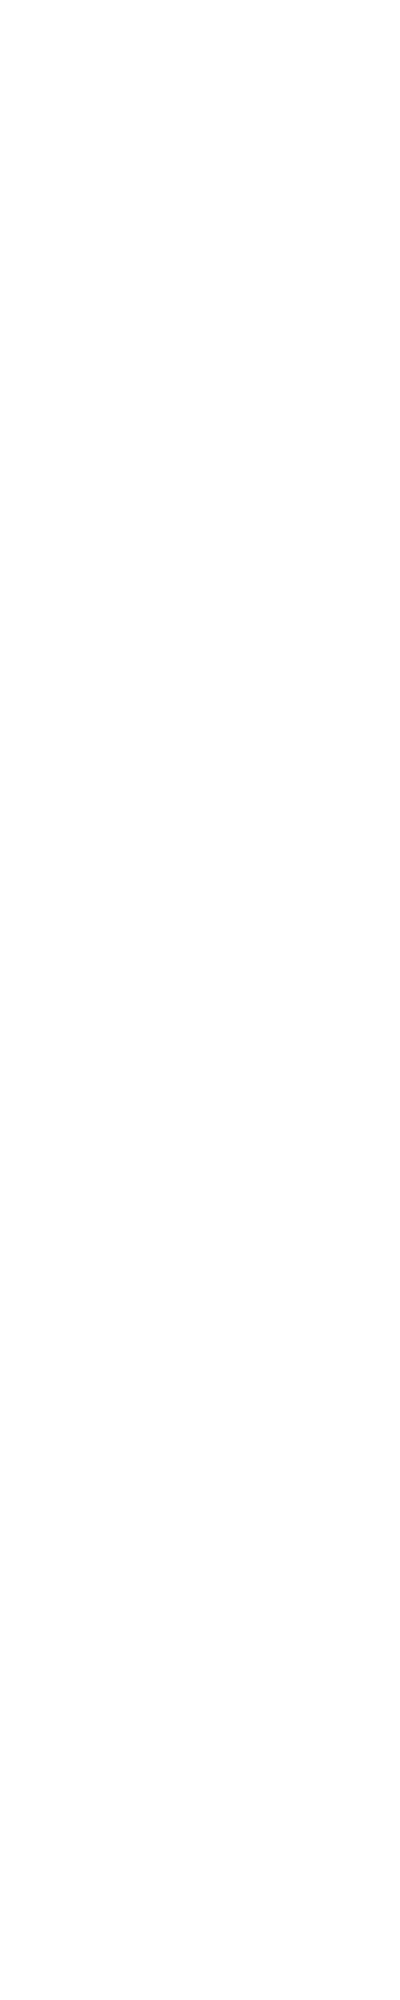

In [150]:
plt.figure(figsize=(4,20))
c = -1
k = 1
distance = dist_ret[ontarget_ret_lax]
for s in range(5):
    regression_weight = (u[:,:cutoffs[c]] @ R[k][c][s].mean(0))[ontarget_ret_lax]
    plt.subplot(5,1,s+1)
    plt.scatter(distance,regression_weight,s=5)
    binmean,binedge,_ = sst.binned_statistic(distance,regression_weight)
    binstd,_,_ = sst.binned_statistic(dist_ret[ontarget_ret_lax],regression_weight,statistic=sst.sem)
    plt.errorbar(0.5*(binedge[:-1]+binedge[1:]),binmean,binstd,c='r')
    plt.plot(0.5*(binedge[:-1]+binedge[1:]),np.zeros_like(binmean),c='k')
    plt.ylim((-0.03,0.03))

<IPython.core.display.Javascript object>


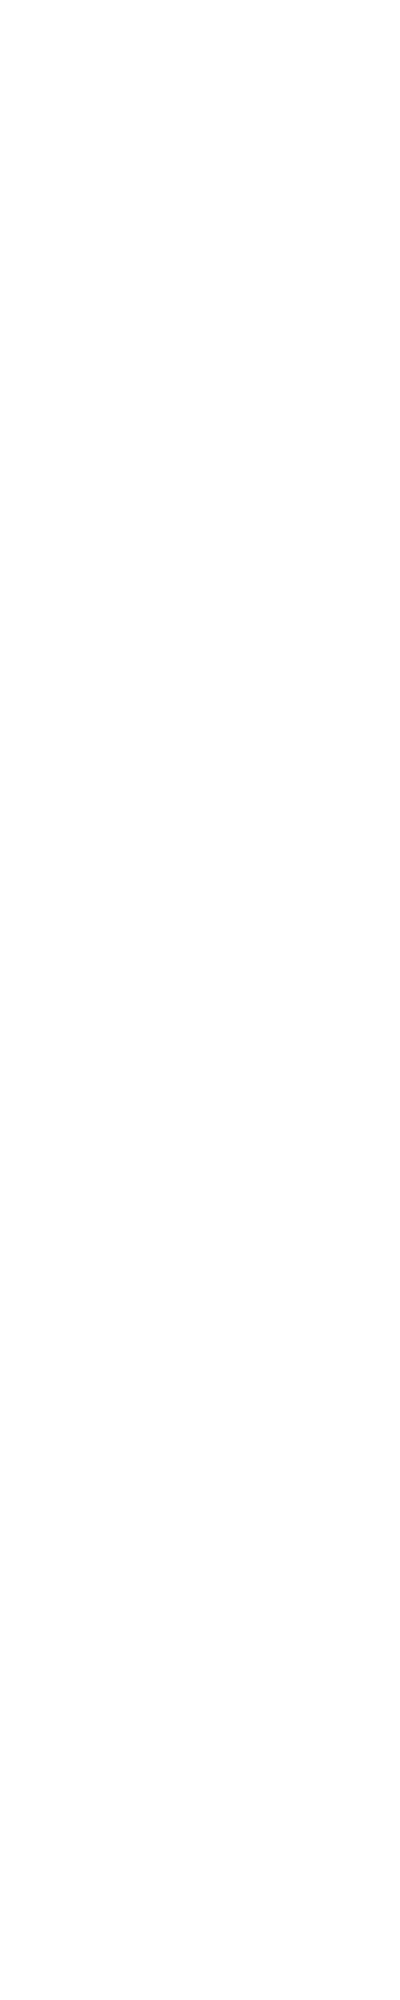

/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/mossing/anaconda3/lib/python3.6/site-packages/matp

In [164]:
plt.figure(figsize=(4,20))
icutoff = -1
k = 1
distance = dist_ret[ontarget_ret_lax]
for s in range(5):
    regression_weight = (u[:,:cutoffs[icutoff]] @ Rlow[k][icutoff][s].mean(0))[ontarget_ret_lax]
    plt.subplot(5,1,s+1)
    plt.scatter(distance,regression_weight,s=5)
    binmean,binedge,_ = sst.binned_statistic(distance,regression_weight)
    binstd,_,_ = sst.binned_statistic(dist_ret[ontarget_ret_lax],regression_weight,statistic=sst.sem)
    plt.errorbar(0.5*(binedge[:-1]+binedge[1:]),binmean,binstd,c='r')
    plt.plot(0.5*(binedge[:-1]+binedge[1:]),np.zeros_like(binmean),c='k')
    plt.ylim((-0.03,0.03))
for s in range(5):
    regression_weight = (u[:,:cutoffs[icutoff]] @ Rhigh[k][icutoff][s].mean(0))[ontarget_ret_lax]
    plt.subplot(5,1,s+1)
    plt.scatter(distance,regression_weight,s=5)
    binmean,binedge,_ = sst.binned_statistic(distance,regression_weight)
    binstd,_,_ = sst.binned_statistic(dist_ret[ontarget_ret_lax],regression_weight,statistic=sst.sem)
    plt.errorbar(0.5*(binedge[:-1]+binedge[1:]),binmean,binstd,c='c')
    plt.plot(0.5*(binedge[:-1]+binedge[1:]),np.zeros_like(binmean),c='k')
    plt.ylim((-0.01,0.02))

In [37]:
def k_and(*args):
    if len(args)>2:
        return np.logical_and(args[0],k_and(*args[1:]))
    else:
        return np.logical_and(args[0],args[1])

/home/mossing/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2245: RuntimeWarning: invalid value encountered in true_divide
  np.expand_dims(sstd, axis=axis))
/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


<IPython.core.display.Javascript object>


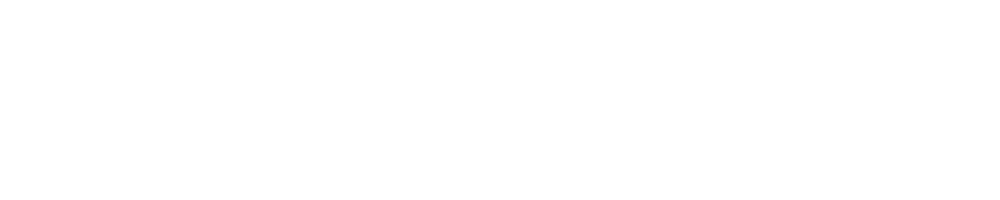

(10, 0, 0, 0.58333333333333337)
(10, 0, 0, 0.58333333333333337)
(10, 0, 0, 0.33333333333333331)
(10, 0, 0, 0.63888888888888884)
(10, 0, 0, 0.61111111111111105)
(10, 0, 0, 0.66666666666666663)
(10, 0, 0, 0.75)
(10, 0, 0, 0.66666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 0, 1, 0.58333333333333337)
(10, 0, 1, 0.5)
(10, 0, 1, 0.58333333333333337)
(10, 0, 1, 0.75)
(10, 0, 1, 0.5)
(10, 0, 1, 0.41666666666666669)
(10, 0, 1, 0.66666666666666663)
(10, 0, 1, 0.66666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 0, 2, 0.58333333333333337)
(10, 0, 2, 0.33333333333333331)
(10, 0, 2, 0.66666666666666663)
(10, 0, 2, 0.91666666666666663)
(10, 0, 2, 0.75)
(10, 0, 2, 0.16666666666666666)
(10, 0, 2, 0.66666666666666663)
(10, 0, 2, 0.66666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 0, 3, 0.5)
(10, 0, 3, 0.75)
(10, 0, 3, 0.83333333333333337)
(10, 0, 3, 0.61111111111111105)
(10, 0, 3, 0.75)
(10, 0, 3, 0.41666666666666669)
(10, 0, 3, 0.75)
(10, 0, 3, 0.83333333333333337)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 0, 4, 0.75)
(10, 0, 4, 0.91666666666666663)
(10, 0, 4, 0.75)
(10, 0, 4, 0.91666666666666663)
(10, 0, 4, 1.0)
(10, 0, 4, 0.83333333333333337)
(10, 0, 4, 0.75)
(10, 0, 4, 0.83333333333333337)
(10, 1, 0, 0.58333333333333337)
(10, 1, 0, 0.83333333333333337)
(10, 1, 0, 0.52777777777777779)
(10, 1, 0, 0.66666666666666663)
(10, 1, 0, 0.33333333333333331)
(10, 1, 0, 0.5)
(10, 1, 0, 0.72222222222222221)
(10, 1, 0, 0.66666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 1, 1, 0.58333333333333337)
(10, 1, 1, 0.91666666666666663)
(10, 1, 1, 0.58333333333333337)
(10, 1, 1, 0.58333333333333337)
(10, 1, 1, 0.58333333333333337)
(10, 1, 1, 0.5)
(10, 1, 1, 0.66666666666666663)
(10, 1, 1, 0.5)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 1, 2, 0.75)
(10, 1, 2, 0.55555555555555547)
(10, 1, 2, 0.66666666666666663)
(10, 1, 2, 0.66666666666666663)
(10, 1, 2, 0.91666666666666663)
(10, 1, 2, 0.83333333333333337)
(10, 1, 2, 0.75)
(10, 1, 2, 0.75)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 1, 3, 0.58333333333333337)
(10, 1, 3, 0.75)
(10, 1, 3, 0.83333333333333337)
(10, 1, 3, 0.91666666666666663)
(10, 1, 3, 0.83333333333333337)
(10, 1, 3, 0.75)
(10, 1, 3, 1.0)
(10, 1, 3, 0.5)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 1, 4, 1.0)
(10, 1, 4, 0.91666666666666663)
(10, 1, 4, 1.0)
(10, 1, 4, 0.91666666666666663)
(10, 1, 4, 0.66666666666666663)
(10, 1, 4, 0.83333333333333337)
(10, 1, 4, 0.83333333333333337)
(10, 1, 4, 0.91666666666666663)
(10, 2, 0, 0.41666666666666669)
(10, 2, 0, 0.5)
(10, 2, 0, 0.66666666666666663)
(10, 2, 0, 0.75)
(10, 2, 0, 0.91666666666666663)
(10, 2, 0, 0.66666666666666663)
(10, 2, 0, 0.5)
(10, 2, 0, 0.91666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 2, 1, 0.83333333333333337)
(10, 2, 1, 0.66666666666666663)
(10, 2, 1, 1.0)
(10, 2, 1, 0.58333333333333337)
(10, 2, 1, 0.66666666666666663)
(10, 2, 1, 0.5)
(10, 2, 1, 0.91666666666666663)
(10, 2, 1, 0.58333333333333337)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 2, 2, 0.83333333333333337)
(10, 2, 2, 1.0)
(10, 2, 2, 0.83333333333333337)
(10, 2, 2, 0.91666666666666663)
(10, 2, 2, 0.66666666666666663)
(10, 2, 2, 0.66666666666666663)
(10, 2, 2, 0.83333333333333337)
(10, 2, 2, 1.0)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 2, 3, 0.83333333333333337)
(10, 2, 3, 0.91666666666666663)
(10, 2, 3, 1.0)
(10, 2, 3, 0.83333333333333337)
(10, 2, 3, 0.91666666666666663)
(10, 2, 3, 0.91666666666666663)
(10, 2, 3, 0.83333333333333337)
(10, 2, 3, 0.91666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 2, 4, 0.91666666666666663)
(10, 2, 4, 1.0)
(10, 2, 4, 1.0)
(10, 2, 4, 1.0)
(10, 2, 4, 0.75)
(10, 2, 4, 0.91666666666666663)
(10, 2, 4, 0.91666666666666663)
(10, 2, 4, 0.91666666666666663)
(10, 3, 0, 0.66666666666666663)
(10, 3, 0, 0.83333333333333337)
(10, 3, 0, 0.75)
(10, 3, 0, 0.5)
(10, 3, 0, 0.75)
(10, 3, 0, 0.61111111111111105)
(10, 3, 0, 0.75)
(10, 3, 0, 0.66666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 3, 1, 1.0)
(10, 3, 1, 1.0)
(10, 3, 1, 0.75)
(10, 3, 1, 1.0)
(10, 3, 1, 1.0)
(10, 3, 1, 1.0)
(10, 3, 1, 0.91666666666666663)
(10, 3, 1, 1.0)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 3, 2, 1.0)
(10, 3, 2, 1.0)
(10, 3, 2, 0.58333333333333337)
(10, 3, 2, 0.41666666666666669)
(10, 3, 2, 0.58333333333333337)
(10, 3, 2, 0.66666666666666663)
(10, 3, 2, 0.91666666666666663)
(10, 3, 2, 0.88888888888888884)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 3, 3, 0.91666666666666663)
(10, 3, 3, 1.0)
(10, 3, 3, 0.75)
(10, 3, 3, 1.0)
(10, 3, 3, 1.0)
(10, 3, 3, 1.0)
(10, 3, 3, 0.91666666666666663)
(10, 3, 3, 0.88888888888888884)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 3, 4, 0.91666666666666663)
(10, 3, 4, 0.83333333333333337)
(10, 3, 4, 1.0)
(10, 3, 4, 0.83333333333333337)
(10, 3, 4, 0.91666666666666663)
(10, 3, 4, 0.91666666666666663)
(10, 3, 4, 1.0)
(10, 3, 4, 1.0)
(10, 4, 0, 1.0)
(10, 4, 0, 0.91666666666666663)
(10, 4, 0, 1.0)
(10, 4, 0, 1.0)
(10, 4, 0, 1.0)
(10, 4, 0, 1.0)
(10, 4, 0, 0.83333333333333337)
(10, 4, 0, 0.75)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 4, 1, 0.91666666666666663)
(10, 4, 1, 0.83333333333333337)
(10, 4, 1, 0.91666666666666663)
(10, 4, 1, 1.0)
(10, 4, 1, 0.91666666666666663)
(10, 4, 1, 1.0)
(10, 4, 1, 1.0)
(10, 4, 1, 0.91666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 4, 2, 0.25)
(10, 4, 2, 0.66666666666666663)
(10, 4, 2, 0.75)
(10, 4, 2, 0.66666666666666663)
(10, 4, 2, 0.83333333333333337)
(10, 4, 2, 0.58333333333333337)
(10, 4, 2, 0.66666666666666663)
(10, 4, 2, 1.0)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 4, 3, 1.0)
(10, 4, 3, 1.0)
(10, 4, 3, 1.0)
(10, 4, 3, 1.0)
(10, 4, 3, 1.0)
(10, 4, 3, 1.0)
(10, 4, 3, 1.0)
(10, 4, 3, 0.91666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(10, 4, 4, 1.0)
(10, 4, 4, 1.0)
(10, 4, 4, 1.0)
(10, 4, 4, 1.0)
(10, 4, 4, 1.0)
(10, 4, 4, 1.0)
(10, 4, 4, 0.91666666666666663)
(10, 4, 4, 1.0)


<IPython.core.display.Javascript object>


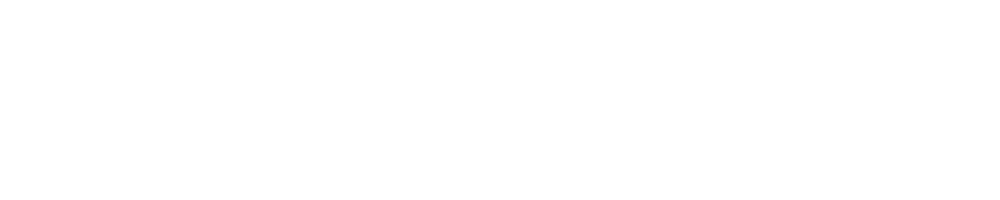

(30, 0, 0, 0.58333333333333337)
(30, 0, 0, 0.75)
(30, 0, 0, 0.5)
(30, 0, 0, 0.80555555555555547)
(30, 0, 0, 0.61111111111111105)
(30, 0, 0, 0.83333333333333337)
(30, 0, 0, 0.41666666666666669)
(30, 0, 0, 0.75)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 0, 1, 0.5)
(30, 0, 1, 0.33333333333333331)
(30, 0, 1, 0.58333333333333337)
(30, 0, 1, 0.58333333333333337)
(30, 0, 1, 0.25)
(30, 0, 1, 0.41666666666666669)
(30, 0, 1, 0.66666666666666663)
(30, 0, 1, 0.66666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 0, 2, 0.58333333333333337)
(30, 0, 2, 0.33333333333333331)
(30, 0, 2, 0.66666666666666663)
(30, 0, 2, 0.52777777777777779)
(30, 0, 2, 0.5)
(30, 0, 2, 0.16666666666666666)
(30, 0, 2, 0.5)
(30, 0, 2, 0.66666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 0, 3, 0.5)
(30, 0, 3, 0.66666666666666663)
(30, 0, 3, 0.66666666666666663)
(30, 0, 3, 0.52777777777777779)
(30, 0, 3, 0.66666666666666663)
(30, 0, 3, 0.16666666666666666)
(30, 0, 3, 0.83333333333333337)
(30, 0, 3, 0.83333333333333337)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 0, 4, 0.58333333333333337)
(30, 0, 4, 0.83333333333333337)
(30, 0, 4, 0.66666666666666663)
(30, 0, 4, 0.91666666666666663)
(30, 0, 4, 0.83333333333333337)
(30, 0, 4, 0.91666666666666663)
(30, 0, 4, 0.91666666666666663)
(30, 0, 4, 0.75)
(30, 1, 0, 0.58333333333333337)
(30, 1, 0, 0.75)
(30, 1, 0, 0.61111111111111105)
(30, 1, 0, 0.91666666666666663)
(30, 1, 0, 0.41666666666666669)
(30, 1, 0, 0.41666666666666669)
(30, 1, 0, 0.61111111111111105)
(30, 1, 0, 0.58333333333333337)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 1, 1, 0.58333333333333337)
(30, 1, 1, 0.75)
(30, 1, 1, 0.66666666666666663)
(30, 1, 1, 0.33333333333333331)
(30, 1, 1, 0.5)
(30, 1, 1, 0.41666666666666669)
(30, 1, 1, 0.58333333333333337)
(30, 1, 1, 0.33333333333333331)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 1, 2, 0.58333333333333337)
(30, 1, 2, 0.80555555555555547)
(30, 1, 2, 0.5)
(30, 1, 2, 0.83333333333333337)
(30, 1, 2, 0.83333333333333337)
(30, 1, 2, 0.83333333333333337)
(30, 1, 2, 0.66666666666666663)
(30, 1, 2, 0.5)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 1, 3, 0.66666666666666663)
(30, 1, 3, 0.75)
(30, 1, 3, 0.75)
(30, 1, 3, 0.83333333333333337)
(30, 1, 3, 0.91666666666666663)
(30, 1, 3, 0.58333333333333337)
(30, 1, 3, 0.91666666666666663)
(30, 1, 3, 0.66666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 1, 4, 1.0)
(30, 1, 4, 0.75)
(30, 1, 4, 1.0)
(30, 1, 4, 0.75)
(30, 1, 4, 0.75)
(30, 1, 4, 0.75)
(30, 1, 4, 0.83333333333333337)
(30, 1, 4, 0.75)
(30, 2, 0, 0.5)
(30, 2, 0, 0.75)
(30, 2, 0, 0.44444444444444442)
(30, 2, 0, 0.58333333333333337)
(30, 2, 0, 0.66666666666666663)
(30, 2, 0, 0.66666666666666663)
(30, 2, 0, 0.75)
(30, 2, 0, 0.75)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 2, 1, 0.91666666666666663)
(30, 2, 1, 0.5)
(30, 2, 1, 0.75)
(30, 2, 1, 0.58333333333333337)
(30, 2, 1, 0.75)
(30, 2, 1, 0.41666666666666669)
(30, 2, 1, 0.83333333333333337)
(30, 2, 1, 0.83333333333333337)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 2, 2, 0.83333333333333337)
(30, 2, 2, 0.91666666666666663)
(30, 2, 2, 0.75)
(30, 2, 2, 0.91666666666666663)
(30, 2, 2, 0.75)
(30, 2, 2, 0.5)
(30, 2, 2, 0.91666666666666663)
(30, 2, 2, 1.0)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 2, 3, 0.66666666666666663)
(30, 2, 3, 1.0)
(30, 2, 3, 0.91666666666666663)
(30, 2, 3, 0.83333333333333337)
(30, 2, 3, 0.91666666666666663)
(30, 2, 3, 0.75)
(30, 2, 3, 0.83333333333333337)
(30, 2, 3, 0.91666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 2, 4, 0.66666666666666663)
(30, 2, 4, 1.0)
(30, 2, 4, 1.0)
(30, 2, 4, 0.83333333333333337)
(30, 2, 4, 0.66666666666666663)
(30, 2, 4, 0.83333333333333337)
(30, 2, 4, 1.0)
(30, 2, 4, 0.83333333333333337)
(30, 3, 0, 0.75)
(30, 3, 0, 0.91666666666666663)
(30, 3, 0, 0.41666666666666669)
(30, 3, 0, 0.66666666666666663)
(30, 3, 0, 0.66666666666666663)
(30, 3, 0, 0.61111111111111105)
(30, 3, 0, 0.66666666666666663)
(30, 3, 0, 0.66666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 3, 1, 0.91666666666666663)
(30, 3, 1, 1.0)
(30, 3, 1, 0.66666666666666663)
(30, 3, 1, 1.0)
(30, 3, 1, 1.0)
(30, 3, 1, 1.0)
(30, 3, 1, 1.0)
(30, 3, 1, 1.0)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 3, 2, 0.83333333333333337)
(30, 3, 2, 0.75)
(30, 3, 2, 0.75)
(30, 3, 2, 0.41666666666666669)
(30, 3, 2, 0.58333333333333337)
(30, 3, 2, 0.58333333333333337)
(30, 3, 2, 0.91666666666666663)
(30, 3, 2, 0.83333333333333337)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 3, 3, 0.83333333333333337)
(30, 3, 3, 1.0)
(30, 3, 3, 1.0)
(30, 3, 3, 1.0)
(30, 3, 3, 0.91666666666666663)
(30, 3, 3, 1.0)
(30, 3, 3, 0.91666666666666663)
(30, 3, 3, 0.88888888888888884)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 3, 4, 0.75)
(30, 3, 4, 0.83333333333333337)
(30, 3, 4, 1.0)
(30, 3, 4, 0.75)
(30, 3, 4, 0.91666666666666663)
(30, 3, 4, 0.91666666666666663)
(30, 3, 4, 1.0)
(30, 3, 4, 0.91666666666666663)
(30, 4, 0, 0.91666666666666663)
(30, 4, 0, 0.66666666666666663)
(30, 4, 0, 1.0)
(30, 4, 0, 1.0)
(30, 4, 0, 1.0)
(30, 4, 0, 0.75)
(30, 4, 0, 0.66666666666666663)
(30, 4, 0, 0.75)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 4, 1, 0.91666666666666663)
(30, 4, 1, 0.83333333333333337)
(30, 4, 1, 0.91666666666666663)
(30, 4, 1, 1.0)
(30, 4, 1, 0.91666666666666663)
(30, 4, 1, 0.91666666666666663)
(30, 4, 1, 1.0)
(30, 4, 1, 0.91666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 4, 2, 0.41666666666666669)
(30, 4, 2, 0.91666666666666663)
(30, 4, 2, 0.75)
(30, 4, 2, 0.58333333333333337)
(30, 4, 2, 0.75)
(30, 4, 2, 0.58333333333333337)
(30, 4, 2, 0.83333333333333337)
(30, 4, 2, 1.0)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 4, 3, 1.0)
(30, 4, 3, 1.0)
(30, 4, 3, 1.0)
(30, 4, 3, 1.0)
(30, 4, 3, 1.0)
(30, 4, 3, 0.91666666666666663)
(30, 4, 3, 1.0)
(30, 4, 3, 0.91666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(30, 4, 4, 1.0)
(30, 4, 4, 1.0)
(30, 4, 4, 1.0)
(30, 4, 4, 1.0)
(30, 4, 4, 1.0)
(30, 4, 4, 1.0)
(30, 4, 4, 0.91666666666666663)
(30, 4, 4, 1.0)


<IPython.core.display.Javascript object>


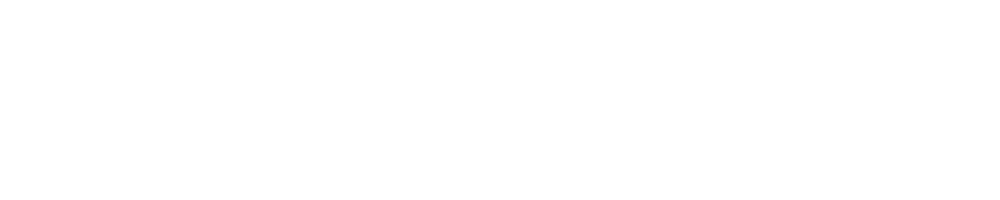

(50, 0, 0, 0.41666666666666669)
(50, 0, 0, 0.58333333333333337)
(50, 0, 0, 0.5)
(50, 0, 0, 0.80555555555555547)
(50, 0, 0, 0.61111111111111105)
(50, 0, 0, 0.83333333333333337)
(50, 0, 0, 0.33333333333333331)
(50, 0, 0, 0.75)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 0, 1, 0.41666666666666669)
(50, 0, 1, 0.33333333333333331)
(50, 0, 1, 0.41666666666666669)
(50, 0, 1, 0.58333333333333337)
(50, 0, 1, 0.25)
(50, 0, 1, 0.33333333333333331)
(50, 0, 1, 0.66666666666666663)
(50, 0, 1, 0.66666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 0, 2, 0.66666666666666663)
(50, 0, 2, 0.41666666666666669)
(50, 0, 2, 0.41666666666666669)
(50, 0, 2, 0.63888888888888884)
(50, 0, 2, 0.58333333333333337)
(50, 0, 2, 0.16666666666666666)
(50, 0, 2, 0.66666666666666663)
(50, 0, 2, 0.66666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 0, 3, 0.41666666666666669)
(50, 0, 3, 0.5)
(50, 0, 3, 0.75)
(50, 0, 3, 0.44444444444444442)
(50, 0, 3, 0.75)
(50, 0, 3, 0.25)
(50, 0, 3, 0.83333333333333337)
(50, 0, 3, 0.83333333333333337)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 0, 4, 0.58333333333333337)
(50, 0, 4, 0.75)
(50, 0, 4, 0.66666666666666663)
(50, 0, 4, 0.91666666666666663)
(50, 0, 4, 1.0)
(50, 0, 4, 0.91666666666666663)
(50, 0, 4, 1.0)
(50, 0, 4, 0.75)
(50, 1, 0, 0.41666666666666669)
(50, 1, 0, 0.75)
(50, 1, 0, 0.61111111111111105)
(50, 1, 0, 0.91666666666666663)
(50, 1, 0, 0.33333333333333331)
(50, 1, 0, 0.16666666666666666)
(50, 1, 0, 0.61111111111111105)
(50, 1, 0, 0.58333333333333337)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 1, 1, 0.58333333333333337)
(50, 1, 1, 0.75)
(50, 1, 1, 0.91666666666666663)
(50, 1, 1, 0.33333333333333331)
(50, 1, 1, 0.5)
(50, 1, 1, 0.33333333333333331)
(50, 1, 1, 0.66666666666666663)
(50, 1, 1, 0.25)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 1, 2, 0.58333333333333337)
(50, 1, 2, 0.72222222222222221)
(50, 1, 2, 0.5)
(50, 1, 2, 0.83333333333333337)
(50, 1, 2, 0.66666666666666663)
(50, 1, 2, 0.83333333333333337)
(50, 1, 2, 0.66666666666666663)
(50, 1, 2, 0.33333333333333331)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 1, 3, 0.5)
(50, 1, 3, 0.66666666666666663)
(50, 1, 3, 0.75)
(50, 1, 3, 0.75)
(50, 1, 3, 0.83333333333333337)
(50, 1, 3, 0.58333333333333337)
(50, 1, 3, 1.0)
(50, 1, 3, 0.66666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 1, 4, 0.91666666666666663)
(50, 1, 4, 0.91666666666666663)
(50, 1, 4, 0.91666666666666663)
(50, 1, 4, 0.66666666666666663)
(50, 1, 4, 0.75)
(50, 1, 4, 0.75)
(50, 1, 4, 0.83333333333333337)
(50, 1, 4, 0.75)
(50, 2, 0, 0.66666666666666663)
(50, 2, 0, 0.58333333333333337)
(50, 2, 0, 0.38888888888888884)
(50, 2, 0, 0.58333333333333337)
(50, 2, 0, 0.58333333333333337)
(50, 2, 0, 0.58333333333333337)
(50, 2, 0, 0.75)
(50, 2, 0, 0.75)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 2, 1, 0.83333333333333337)
(50, 2, 1, 0.5)
(50, 2, 1, 0.75)
(50, 2, 1, 0.75)
(50, 2, 1, 0.75)
(50, 2, 1, 0.41666666666666669)
(50, 2, 1, 0.83333333333333337)
(50, 2, 1, 0.66666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 2, 2, 1.0)
(50, 2, 2, 1.0)
(50, 2, 2, 0.83333333333333337)
(50, 2, 2, 0.91666666666666663)
(50, 2, 2, 0.75)
(50, 2, 2, 0.5)
(50, 2, 2, 0.83333333333333337)
(50, 2, 2, 1.0)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 2, 3, 0.66666666666666663)
(50, 2, 3, 1.0)
(50, 2, 3, 0.83333333333333337)
(50, 2, 3, 0.83333333333333337)
(50, 2, 3, 0.83333333333333337)
(50, 2, 3, 0.58333333333333337)
(50, 2, 3, 1.0)
(50, 2, 3, 0.75)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 2, 4, 0.58333333333333337)
(50, 2, 4, 0.91666666666666663)
(50, 2, 4, 0.91666666666666663)
(50, 2, 4, 0.83333333333333337)
(50, 2, 4, 0.66666666666666663)
(50, 2, 4, 0.83333333333333337)
(50, 2, 4, 1.0)
(50, 2, 4, 0.58333333333333337)
(50, 3, 0, 0.75)
(50, 3, 0, 0.75)
(50, 3, 0, 0.58333333333333337)
(50, 3, 0, 0.41666666666666669)
(50, 3, 0, 0.58333333333333337)
(50, 3, 0, 0.44444444444444442)
(50, 3, 0, 0.58333333333333337)
(50, 3, 0, 0.58333333333333337)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 3, 1, 1.0)
(50, 3, 1, 1.0)
(50, 3, 1, 0.58333333333333337)
(50, 3, 1, 1.0)
(50, 3, 1, 1.0)
(50, 3, 1, 1.0)
(50, 3, 1, 0.91666666666666663)
(50, 3, 1, 1.0)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 3, 2, 0.75)
(50, 3, 2, 0.75)
(50, 3, 2, 0.75)
(50, 3, 2, 0.41666666666666669)
(50, 3, 2, 0.66666666666666663)
(50, 3, 2, 0.58333333333333337)
(50, 3, 2, 0.91666666666666663)
(50, 3, 2, 0.72222222222222221)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 3, 3, 0.83333333333333337)
(50, 3, 3, 0.83333333333333337)
(50, 3, 3, 0.83333333333333337)
(50, 3, 3, 1.0)
(50, 3, 3, 1.0)
(50, 3, 3, 1.0)
(50, 3, 3, 0.91666666666666663)
(50, 3, 3, 0.88888888888888884)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 3, 4, 0.91666666666666663)
(50, 3, 4, 0.66666666666666663)
(50, 3, 4, 1.0)
(50, 3, 4, 0.66666666666666663)
(50, 3, 4, 0.91666666666666663)
(50, 3, 4, 0.91666666666666663)
(50, 3, 4, 1.0)
(50, 3, 4, 0.83333333333333337)
(50, 4, 0, 0.66666666666666663)
(50, 4, 0, 0.58333333333333337)
(50, 4, 0, 0.75)
(50, 4, 0, 1.0)
(50, 4, 0, 1.0)
(50, 4, 0, 0.83333333333333337)
(50, 4, 0, 0.58333333333333337)
(50, 4, 0, 0.58333333333333337)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 4, 1, 0.91666666666666663)
(50, 4, 1, 0.75)
(50, 4, 1, 0.91666666666666663)
(50, 4, 1, 0.91666666666666663)
(50, 4, 1, 0.91666666666666663)
(50, 4, 1, 0.91666666666666663)
(50, 4, 1, 1.0)
(50, 4, 1, 0.83333333333333337)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 4, 2, 0.33333333333333331)
(50, 4, 2, 0.83333333333333337)
(50, 4, 2, 0.66666666666666663)
(50, 4, 2, 0.58333333333333337)
(50, 4, 2, 0.83333333333333337)
(50, 4, 2, 0.5)
(50, 4, 2, 0.83333333333333337)
(50, 4, 2, 1.0)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 4, 3, 1.0)
(50, 4, 3, 1.0)
(50, 4, 3, 1.0)
(50, 4, 3, 1.0)
(50, 4, 3, 0.91666666666666663)
(50, 4, 3, 1.0)
(50, 4, 3, 1.0)
(50, 4, 3, 0.91666666666666663)


/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(50, 4, 4, 1.0)
(50, 4, 4, 1.0)
(50, 4, 4, 1.0)
(50, 4, 4, 1.0)
(50, 4, 4, 1.0)
(50, 4, 4, 1.0)
(50, 4, 4, 0.91666666666666663)
(50, 4, 4, 1.0)


In [136]:
nkey = len(keylist)
R = [None]*nkey
top_score = [None]*nkey
cutoffs = np.round(np.linspace(10,50,3)).astype('int')
# cutoffs = (50,)
for k in (1,): #range(len(keylist)):
    R[k] = [None]*len(cutoffs)
    data = sst.zscore(ds[keylist[k]]['decon'][()],axis=1)
    data[np.isnan(data)] = 0
    u,sigma,v = np.linalg.svd(data)
    nangle = 8
    
    pval_ret = ds[keylist[k]]['rf_mapping_pval'][()]
    dist_ret = ds[keylist[k]]['rf_distance_deg'][()]
    ontarget_ret_lax = np.logical_and(dist_ret<40,pval_ret<0.05)
    running_speed_cm_s = ds[keylist[k]]['running_speed_cm_s'][()]
    running = running_speed_cm_s>7
    if np.logical_and(ontarget_ret_lax.sum()>100,running.mean()>0.5):
        size = ds[keylist[k]]['stimulus_id'][()][0]
        contrast = ds[keylist[k]]['stimulus_id'][()][1]
        angle = ds[keylist[k]]['stimulus_id'][()][-1]
        top_score[k] = np.zeros((len(cutoffs),5,5,8))
        for icutoff,cutoff in enumerate(cutoffs):
            R[k][icutoff] = np.zeros((5,5,8,cutoff))
            plt.figure(figsize=(10,2))
            for s in range(5):
                for c in range(5):
                    plt.subplot(1,5,s+1)
                    for i in range(nangle):
                        stim_of_interest_all_contrast = k_and(angle==i,size==s,np.logical_or(contrast==c,contrast==c+1),running)
                        X = (np.diag(sigma[:cutoff]) @ v[:cutoff,:]).T[stim_of_interest_all_contrast]
                        uangle = np.unique(angle)
                        y = contrast[stim_of_interest_all_contrast]==c+1 #>0

                        na = 50
                        sc = np.zeros((na,))
                        alphas = np.logspace(-2,2,na)
                        for ia,alpha in enumerate(alphas):
                            linreg = sklearn.linear_model.LogisticRegression(C=alpha)
                            reg = linreg.fit(X,y)
                            scores = sklearn.model_selection.cross_validate(linreg,X,y)
                            pred = sklearn.model_selection.cross_val_predict(linreg,X,y)
                            sc[ia] = scores['test_score'].mean()
                        best_alpha = np.argmax(sc)
                        top_score[k][icutoff,s,c,i] = sc.max()
                        print((cutoff,s,c,top_score[k][icutoff,s,c,i]))
                        linreg = sklearn.linear_model.LogisticRegression(C=alphas[best_alpha])
                        reg = linreg.fit(X,y)

                        R[k][icutoff][s,c,i] = reg.coef_

                        Xall = v[:cutoff,:].T[stim_of_interest_all_contrast]

                        ypred = reg.predict(Xall)

                        yactual = contrast[stim_of_interest_all_contrast]

                        plt.scatter(yactual+1*np.linspace(0,1,yactual.size),ypred,s=5)

<IPython.core.display.Javascript object>


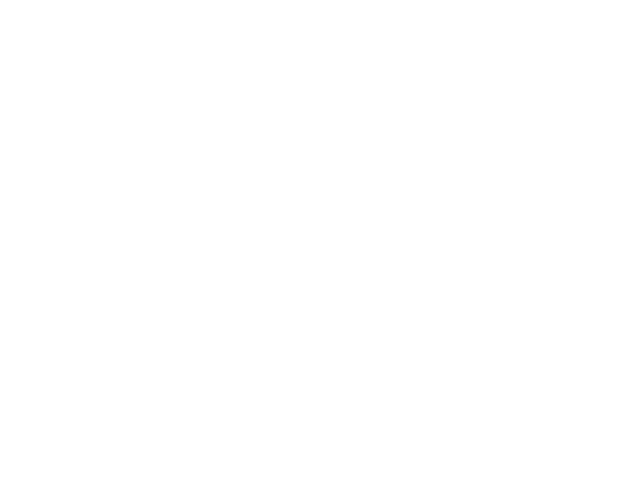

In [147]:
fig = plt.figure()
icutoff = 0
for icutoff in range(3):
    ax = fig.add_subplot(1,3,icutoff+1,projection='3d')
    for s in range(5):
        x = np.cumsum(np.concatenate(((0,),R[k][icutoff][s,:,:,0].mean(1))))
        y = np.cumsum(np.concatenate(((0,),R[k][icutoff][s,:,:,1].mean(1))))
        z = np.cumsum(np.concatenate(((0,),R[k][icutoff][s,:,:,2].mean(1))))
        ax.plot(x,y,z) #,np.cumsum(R[k][icutoff][s,:,:,2].mean(1)))

<IPython.core.display.Javascript object>


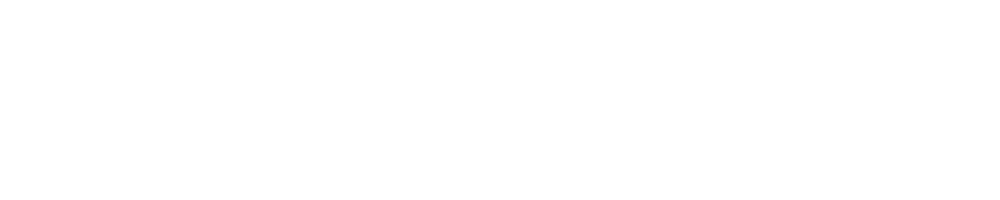

<IPython.core.display.Javascript object>


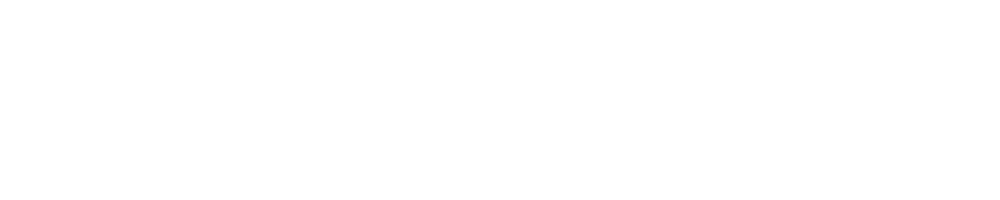

In [180]:
fig = plt.figure(figsize=(10,2))
for s in range(5):
    ax = plt.subplot(1,5,s+1,projection='3d')
    ax.view_init(0, 45)
    for c in range(6):
        lkat = k_and(contrast==c,size==s,angle==1)
        ax.scatter(v[0][lkat],v[1][lkat],v[2][lkat])
    ax.axis('off')
    ax.set_xlim(-0.1,0.1)
    ax.set_ylim(-0.1,0.1)
    ax.set_zlim(-0.1,0.1)   
    
fig = plt.figure(figsize=(10,2))
for s in range(5):
    ax = plt.subplot(1,5,s+1,projection='3d')
    ax.view_init(0, -45)
    for c in range(6):
        lkat = k_and(contrast==c,size==s,angle==1)
        ax.scatter(v[0][lkat],v[1][lkat],v[2][lkat])
    ax.axis('off')
    ax.set_xlim(-0.1,0.1)
    ax.set_ylim(-0.1,0.1)
    ax.set_zlim(-0.1,0.1)

<IPython.core.display.Javascript object>


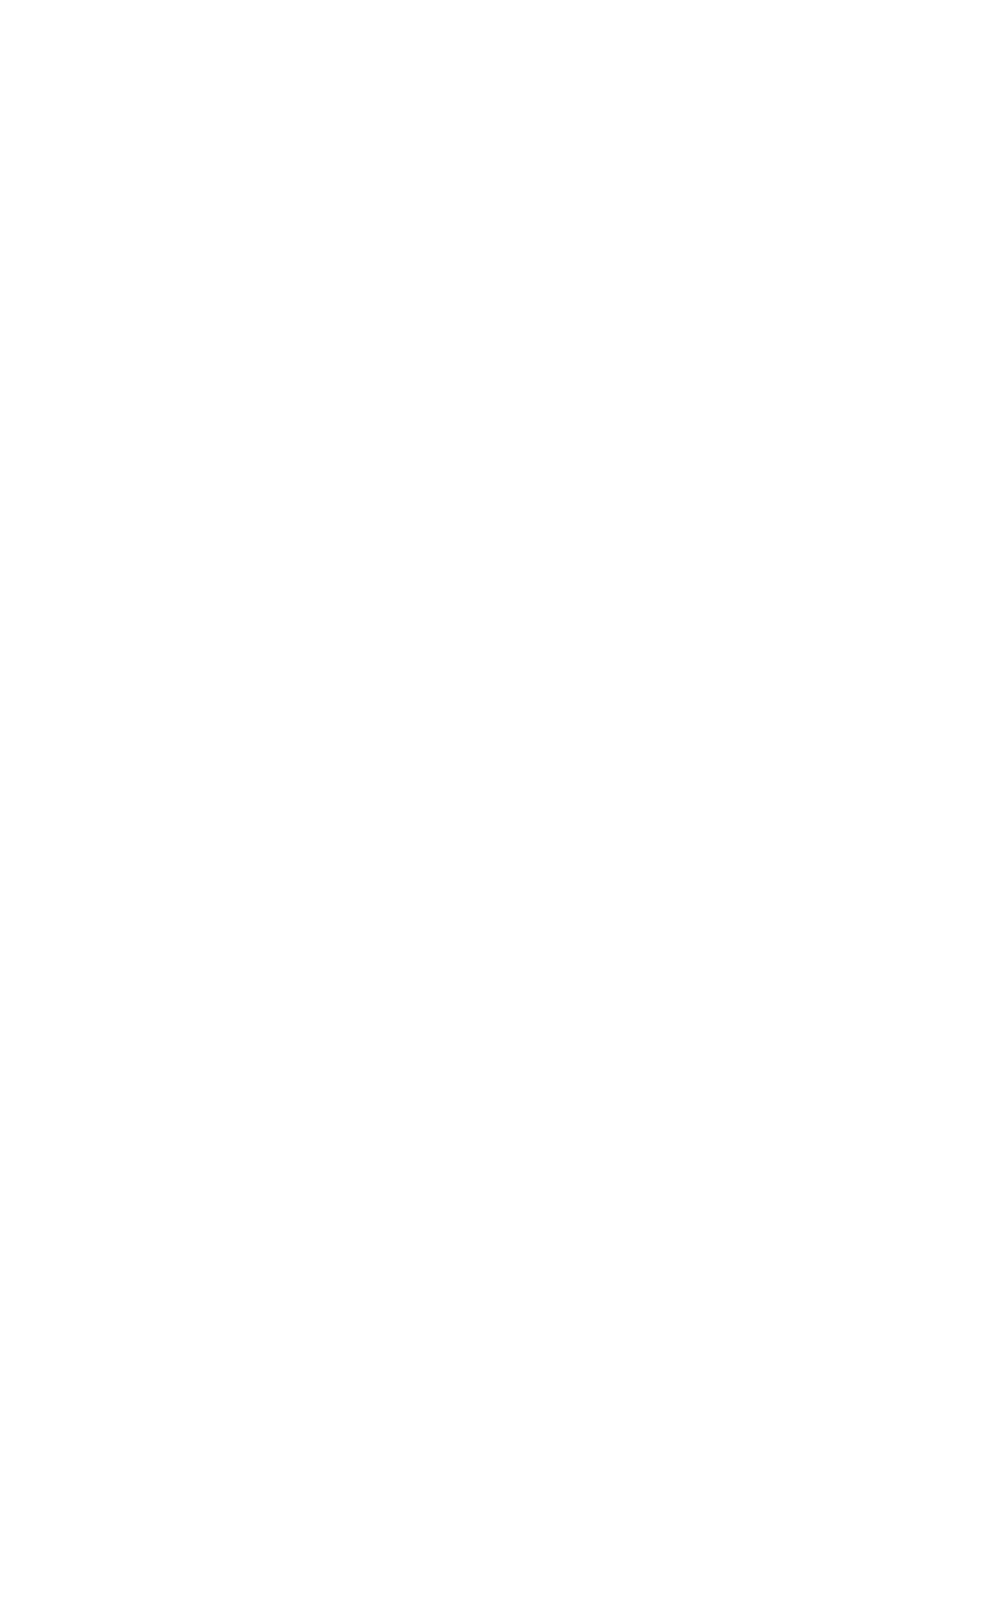

<IPython.core.display.Javascript object>


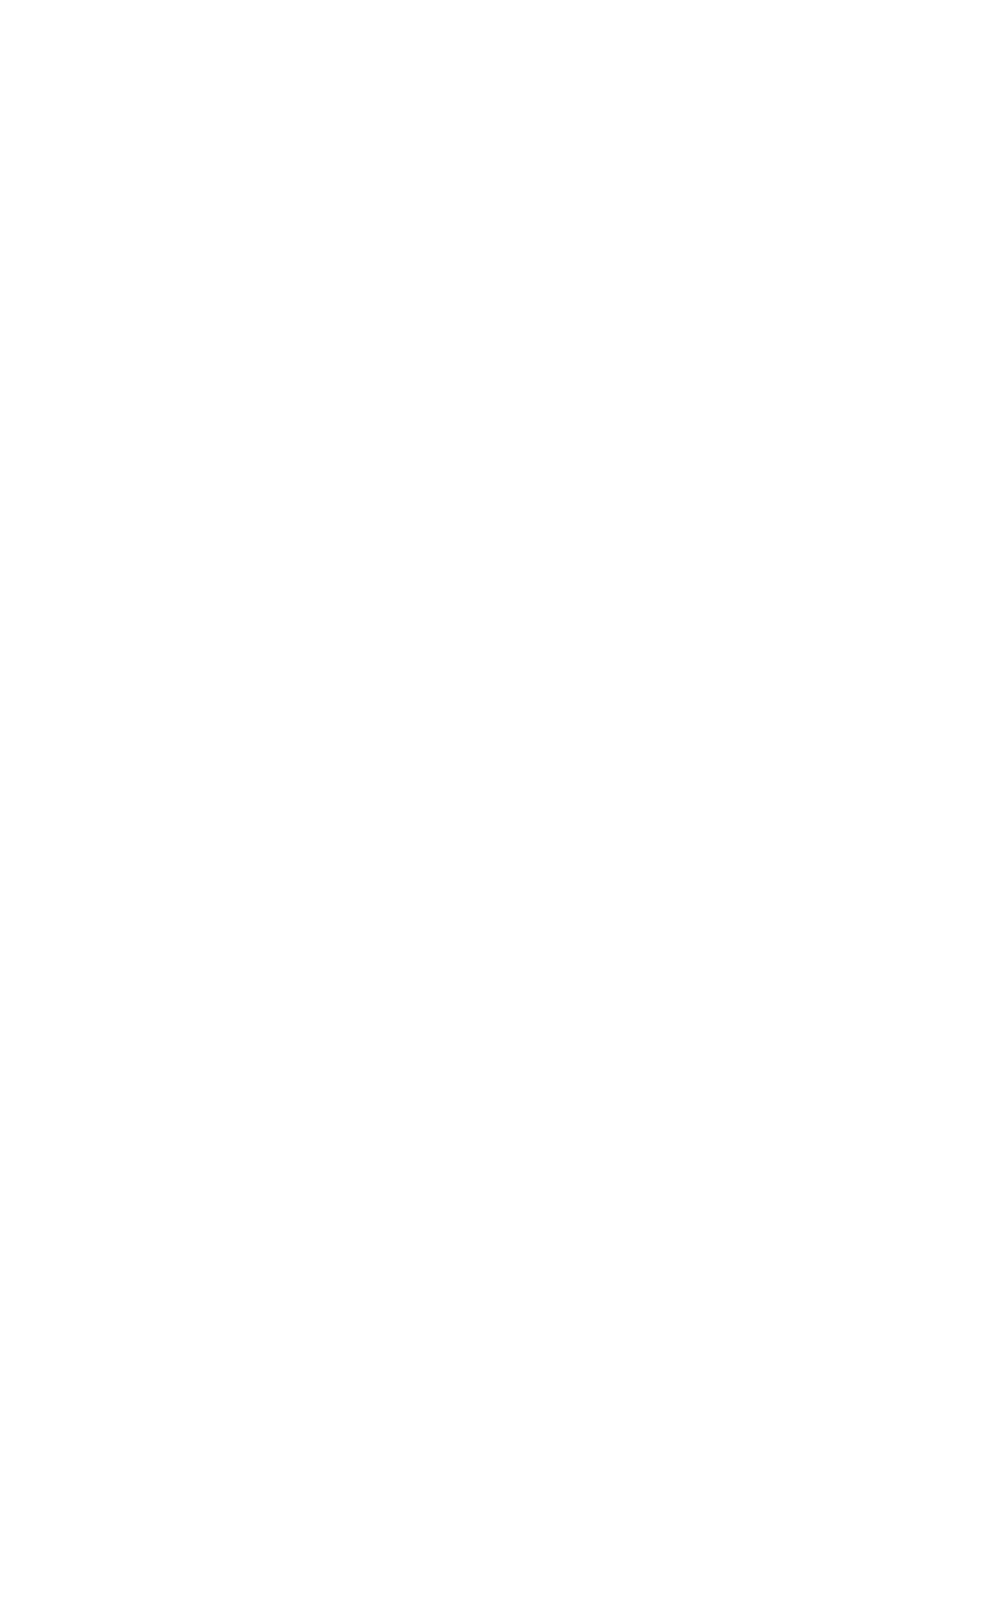

In [182]:
fig = plt.figure(figsize=(10,16))
for s in range(5):
    for a in range(8):
        ax = plt.subplot(8,5,a*5+s+1,projection='3d')
        ax.view_init(0, 45)
        for c in range(6):
            lkat = k_and(contrast==c,size==s,angle==a)
            ax.scatter(v[0][lkat],v[1][lkat],v[2][lkat])
        ax.axis('off')
        ax.set_xlim(-0.1,0.1)
        ax.set_ylim(-0.1,0.1)
        ax.set_zlim(-0.1,0.1)
    
fig = plt.figure(figsize=(10,16))
for s in range(5):
    for a in range(8):
        ax = plt.subplot(8,5,a*5+s+1,projection='3d')
        ax.view_init(0, -45)
        for c in range(6):
            lkat = k_and(contrast==c,size==s,angle==a)
            ax.scatter(v[0][lkat],v[1][lkat],v[2][lkat])
        ax.axis('off')
        ax.set_xlim(-0.1,0.1)
        ax.set_ylim(-0.1,0.1)
        ax.set_zlim(-0.1,0.1)

<IPython.core.display.Javascript object>


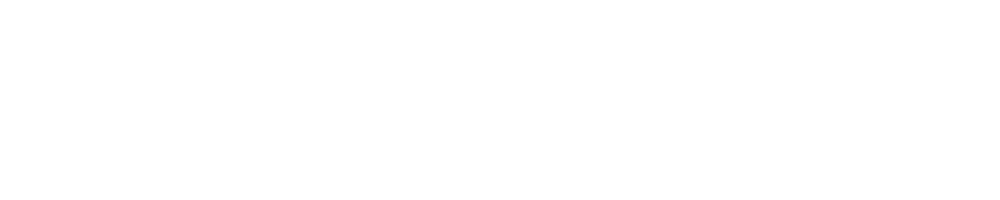

<IPython.core.display.Javascript object>


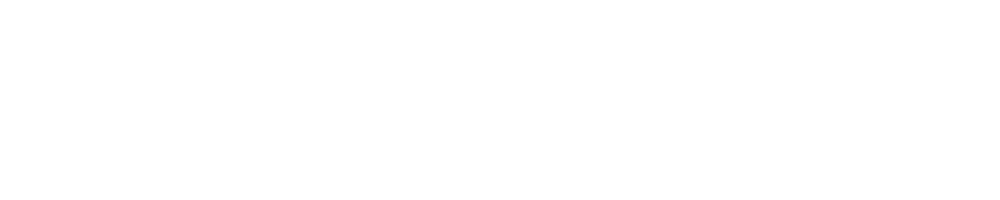

In [174]:
fig = plt.figure(figsize=(10,2))
for s in range(5):
    ax = plt.subplot(1,5,s+1,projection='3d')
    ax.view_init(0, 45)
    for c in range(6):
        lkat = k_and(contrast==c,size==s)
        ax.scatter(v[0][lkat],v[1][lkat],v[5][lkat],alpha=0.3)
    ax.axis('off')
    ax.set_xlim(-0.1,0.1)
    ax.set_ylim(-0.1,0.1)
    ax.set_zlim(-0.1,0.1)   
    
fig = plt.figure(figsize=(10,2))
for s in range(5):
    ax = plt.subplot(1,5,s+1,projection='3d')
    ax.view_init(0, -45)
    for c in range(6):
        lkat = k_and(contrast==c,size==s)
        ax.scatter(v[0][lkat],v[1][lkat],v[7][lkat],alpha=0.3)
    ax.axis('off')
    ax.set_xlim(-0.1,0.1)
    ax.set_ylim(-0.1,0.1)
    ax.set_zlim(-0.1,0.1)

<IPython.core.display.Javascript object>


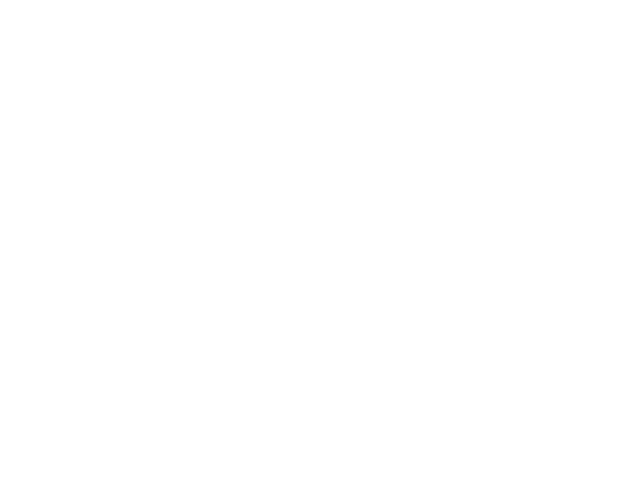

In [140]:
plt.figure()
plt.plot(top_score[k].mean(-1).mean(-1))

<IPython.core.display.Javascript object>


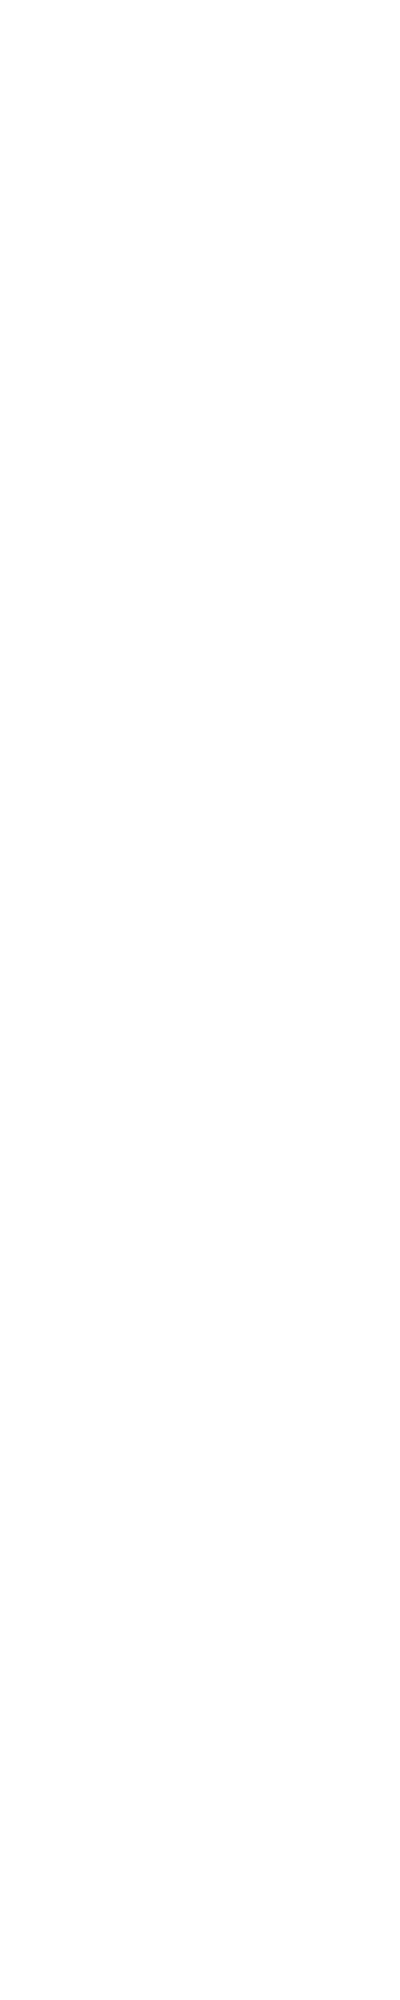

In [186]:
plt.figure(figsize=(4,20))
c = -1
k = 1
distance = dist_ret[ontarget_ret_lax]
N = 8
for s in range(N):
    regression_weight = u[:,s][ontarget_ret_lax]
    plt.subplot(N,1,s+1)
    plt.scatter(distance,regression_weight,s=5)
    binmean,binedge,_ = sst.binned_statistic(distance,regression_weight)
    binstd,_,_ = sst.binned_statistic(dist_ret[ontarget_ret_lax],regression_weight,statistic=sst.sem)
    plt.errorbar(0.5*(binedge[:-1]+binedge[1:]),binmean,binstd,c='r')
    plt.plot(0.5*(binedge[:-1]+binedge[1:]),np.zeros_like(binmean),c='k')
#     plt.ylim((-0.03,0.03))

<IPython.core.display.Javascript object>


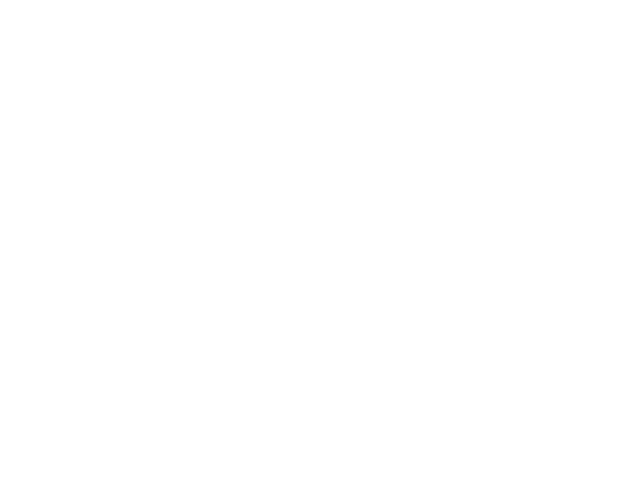

In [191]:
plt.figure()#figsize=(4,20))
c = -1
k = 1
distance = dist_ret[ontarget_ret_lax]
N = 8
regression_weight = -u[:,0][ontarget_ret_lax]+u[:,1][ontarget_ret_lax]
plt.scatter(distance,regression_weight,s=5)
binmean,binedge,_ = sst.binned_statistic(distance,regression_weight)
binstd,_,_ = sst.binned_statistic(dist_ret[ontarget_ret_lax],regression_weight,statistic=sst.sem)
plt.errorbar(0.5*(binedge[:-1]+binedge[1:]),binmean,binstd,c='r')
plt.plot(0.5*(binedge[:-1]+binedge[1:]),np.zeros_like(binmean),c='k')

In [190]:
plt.close('all')